In [474]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Importation des données

In [475]:
data_path = "../data/welddb.data"
column_names = [
    'C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co', 'W', 
    'O', 'Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb', 
    'Current', 'Voltage', 'AC_DC', 'Electrode_polarity', 'Heat_input', 'Interpass_temp',  
    'Weld_type', 'PWHT_temp', 'PWHT_time', 
    'Yield_strength', 'UTS', 'Elongation', 'Reduction_area',  
    'Charpy_temp', 'Charpy_impact', 'Hardness', 'FATT_50', 
    'Primary_ferrite', 'Ferrite_2nd_phase', 'Acicular_ferrite', 'Martensite', 'Ferrite_carbide', 
    'Weld_ID' 
]
df = pd.read_csv(data_path, sep='\s+', names=column_names, na_values='N') # as the NaN values are represented by 'N' in the data file
df

,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,Charpy_temp,Charpy_impact,Hardness,FATT_50,Primary_ferrite,Ferrite_2nd_phase,Acicular_ferrite,Martensite,Ferrite_carbide,Weld_ID
0,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aaw
1,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,-28.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aawch
2,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,-38.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aht
3,0.037,0.31,1.03,0.007,0.014,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Baw
4,0.037,0.31,1.03,0.007,0.014,0.00,NaN,NaN,NaN,NaN,...,-48.0,100.0,NaN,NaN,32,28.0,40.0,0.0,0.0,Evans-Ni/CMn-1990/1991-0Bawch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.6,0.98,0.18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX35
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.4,0.94,0.19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX36
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.2,0.94,0.02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX37
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.4,0.97,0.17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX38


In [476]:
categorical_cols = ['AC_DC', 'Electrode_polarity', 'Weld_type', 'Weld_ID']
chemical_cols = ['C','Si','Mn','S','P','Ni','Cr','Mo','V','Cu','Co',
                 'W','O','Ti','N','Al','B','Nb','Sn','As','Sb']

# Data statistics

In [477]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   C                   1652 non-null   float64
 1   Si                  1652 non-null   float64
 2   Mn                  1652 non-null   float64
 3   S                   1648 non-null   object 
 4   P                   1642 non-null   float64
 5   Ni                  697 non-null    float64
 6   Cr                  784 non-null    float64
 7   Mo                  793 non-null    object 
 8   V                   928 non-null    object 
 9   Cu                  578 non-null    object 
 10  Co                  129 non-null    object 
 11  W                   75 non-null     object 
 12  O                   1256 non-null   float64
 13  Ti                  935 non-null    object 
 14  N                   1242 non-null   object 
 15  Al                  905 non-null    object 
 16  B     

On remarque que beaucoup de colonnes ont une majorité de valeurs manquantes. 

In [478]:
print(f"Proportion of missing values: {df.isna().sum().sum() / df.size}")

Proportion of missing values: 0.45593495487563285


Text(0, 0.5, 'Proportion of missing values')

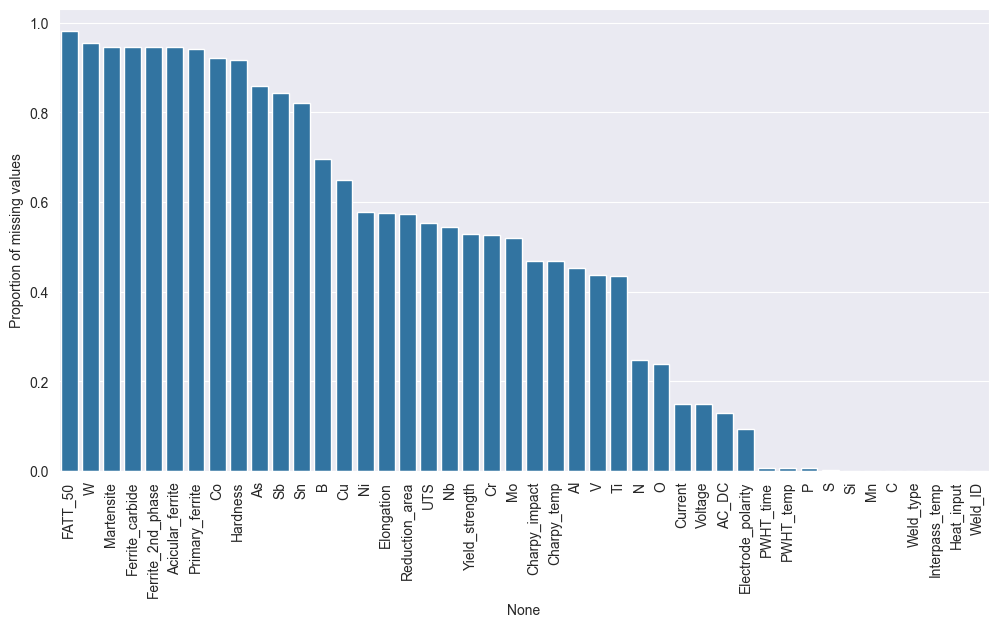

In [479]:
df_missing = df.isna().sum().sort_values(ascending=False) / len(df)
plt.figure(figsize=(12,6))
sns.barplot(x=df_missing.index, y=df_missing.values)
plt.xticks(rotation=90)
plt.ylabel('Proportion of missing values')

Text(0, 0.5, 'Proportion of missing values')

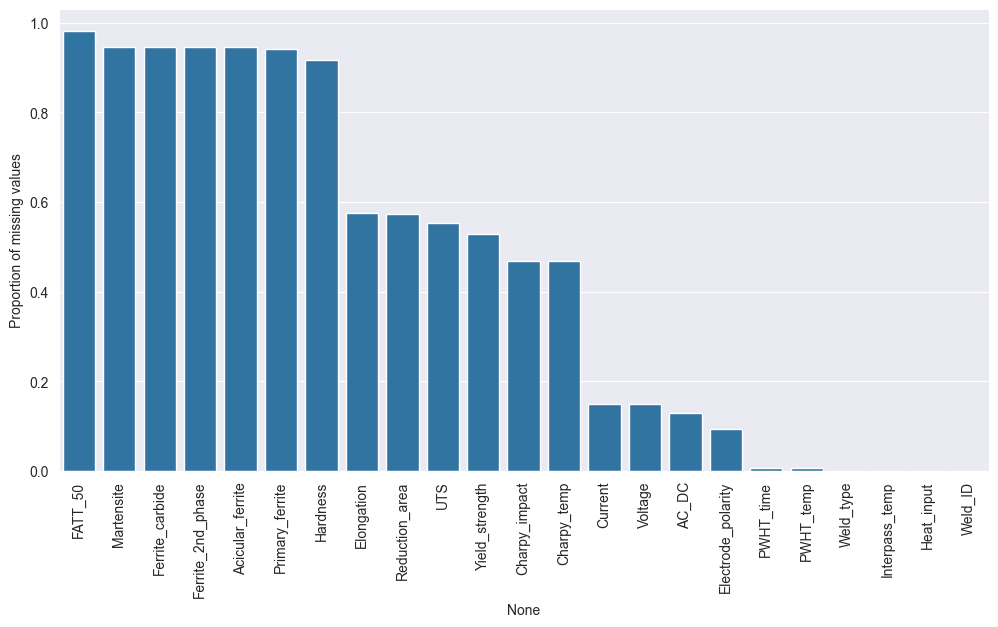

In [480]:
df_missing_non_chemical = df_missing.drop(chemical_cols)
plt.figure(figsize=(12,6))
sns.barplot(x=df_missing_non_chemical.index, y=df_missing_non_chemical.values)
plt.xticks(rotation=90)
plt.ylabel('Proportion of missing values')

In [481]:
df_missing_non_chemical * len(df)

FATT_50               1621.0
Martensite            1563.0
Ferrite_carbide       1563.0
Ferrite_2nd_phase     1562.0
Acicular_ferrite      1562.0
Primary_ferrite       1554.0
Hardness              1514.0
Elongation             952.0
Reduction_area         947.0
UTS                    914.0
Yield_strength         872.0
Charpy_impact          773.0
Charpy_temp            773.0
Current                248.0
Voltage                248.0
AC_DC                  215.0
Electrode_polarity     156.0
PWHT_time               13.0
PWHT_temp               13.0
Weld_type                0.0
Interpass_temp           0.0
Heat_input               0.0
Weld_ID                  0.0
dtype: float64

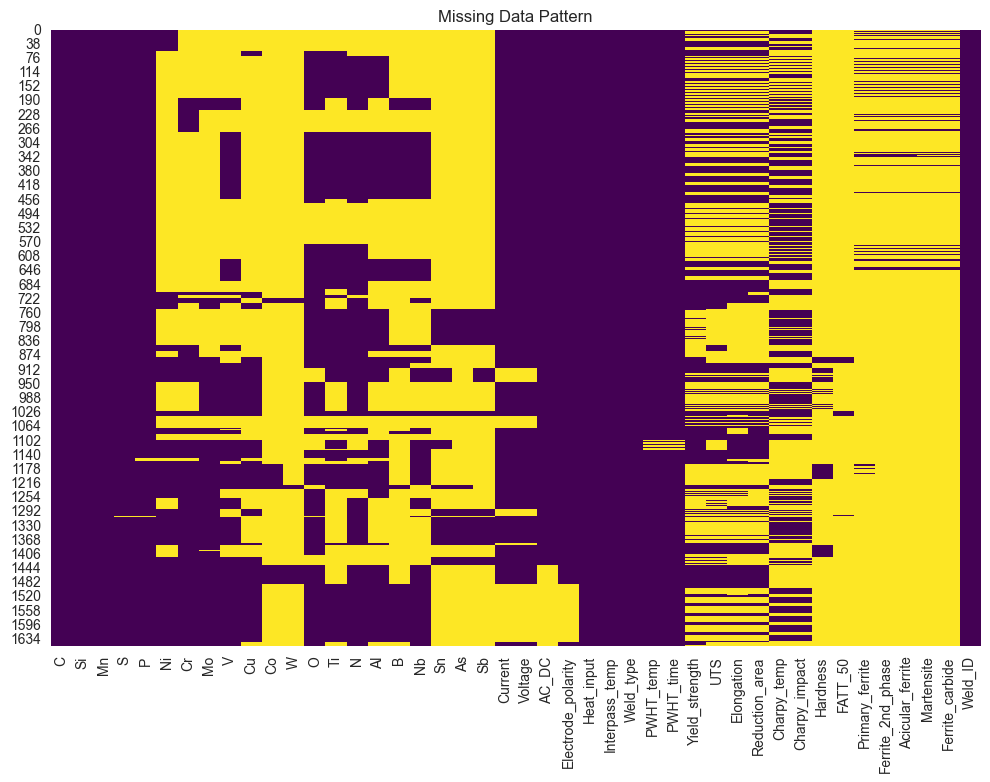

In [482]:
# Visualize missing data pattern
plt.figure(figsize=(12,8))
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title('Missing Data Pattern')
plt.show()

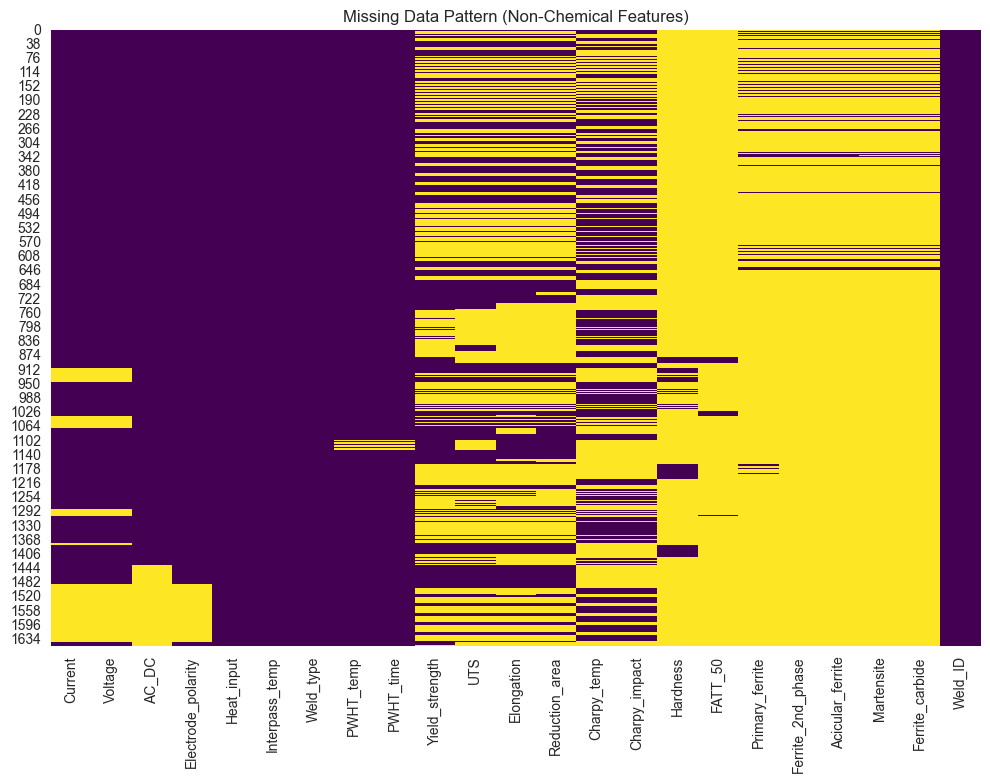

In [483]:
# visualize for non-chemical features only
plt.figure(figsize=(12,8))
sns.heatmap(df.drop(columns=chemical_cols).isna(), cbar=False, cmap='viridis')
plt.title('Missing Data Pattern (Non-Chemical Features)')
plt.show()

On a des colonnes qui ont l'air d'être toujours présentes ensemble et d'autres alors que les autres sont absentes. Comme si l'on avait fusionner des datasets différents sur des colonnes en commun. 

Les colonnes communes seraient les colonnes des éléments chimiques, et les colonnes : ["Current", "Voltage", "AC_DC", "Electrode_polarity", "Heat_input", "Interpass_temp", "Weld_type", "PWHT_temp", "PWHT_time"].

Les colonnes du premier dataset : ["Yield_strength", "UTS", "Elongation", "Reduction_area"]

Deuxième : ["Charpy_temp", "Charpy_impact"]

Troisième : ["Primary_ferrite", "Ferrite_2nd_phase", "Acicular_ferrite", "Martensite", "Ferrite_carbide"]

Hardness et FATT_50 ont l'air seuls. 

In [484]:
common_columns = chemical_cols + ["Current", "Voltage", "AC_DC", "Electrode_polarity", "Heat_input", "Interpass_temp", "Weld_type", "PWHT_temp", "PWHT_time"]
first_dataset_cols = ["Yield_strength", "UTS", "Elongation", "Reduction_area"]
second_dataset_cols = ["Charpy_temp", "Charpy_impact"]
third_dataset_cols = ["Primary_ferrite", "Ferrite_2nd_phase", "Acicular_ferrite", "Martensite", "Ferrite_carbide"]

df_first = df[common_columns + first_dataset_cols]
df_second = df[common_columns + second_dataset_cols]
df_third = df[common_columns + third_dataset_cols]

In [485]:
idx_1 = set(list(df_first.dropna(subset=first_dataset_cols, how='all').index))
idx_2 = set(list(df_second.dropna(subset=second_dataset_cols, how='all').index))
idx_3 = set(list(df_third.dropna(subset=third_dataset_cols, how='all').index))

print(f"intersection of all three datasets: {idx_1 & idx_2 & idx_3}")
print(f"intersection of first and second datasets: {idx_1 & idx_2}")
print(f"intersection of first and third datasets: {idx_1 & idx_3}")
print(f"intersection of second and third datasets: {idx_2 & idx_3}")

intersection of all three datasets: set()
intersection of first and second datasets: {1024, 1025, 2, 1026, 1027, 5, 1028, 1029, 8, 1030, 1031, 11, 1032, 1033, 1034, 1035, 24, 27, 30, 33, 36, 39, 42, 48, 51, 54, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 617, 620, 623, 626, 629, 632, 635, 638, 641, 644, 647, 650, 653, 656, 659, 662, 665, 668, 671, 674, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 217, 220, 223, 226, 239, 242, 245, 248, 251, 254, 257, 260, 263, 266, 269, 335, 338, 341, 344, 347, 350, 353, 356, 359, 362, 365, 368, 371, 374, 377, 380, 383, 895, 896, 386, 897, 898, 389, 899, 900, 901, 902, 903, 395, 904, 905, 398, 906, 401, 404, 407, 410, 413, 416, 419, 422, 425, 428, 431, 434, 437, 440, 443, 446, 449, 452}
intersection of first and third datasets: set()
intersection of second and third datasets: {640, 643, 4, 261, 10, 267, 394, 397, 270, 400, 403, 406, 26, 32, 38, 424, 427, 44, 430, 433

In [486]:
print(f"Number of samples in intersection of first and second datasets: {len(idx_1 & idx_2)}")
print(f"Number of samples in intersection of first and third datasets: {len(idx_1 & idx_3)}")
print(f"Number of samples in intersection of second and third datasets: {len(idx_2 & idx_3)}")
print("\n"+"_"*90+"\n")
print(f"Part de valeurs du dataset 2 présentes dans le dataset 1: {len(idx_1 & idx_2)/len(idx_1):.2%}")
print(f"Part de valeurs du dataset 1 présentes dans le dataset 2: {len(idx_1 & idx_2)/len(idx_2):.2%}")
print(f"Part de valeurs du dataset 3 présentes dans le dataset 1: {len(idx_1 & idx_3)/len(idx_1):.2%}")
print(f"Part de valeurs du dataset 1 présentes dans le dataset 3: {len(idx_1 & idx_3)/len(idx_3):.2%}")
print(f"Part de valeurs du dataset 3 présentes dans le dataset 2: {len(idx_2 & idx_3)/len(idx_2):.2%}")
print(f"Part de valeurs du dataset 2 présentes dans le dataset 3: {len(idx_2 & idx_3)/len(idx_3):.2%}")

Number of samples in intersection of first and second datasets: 144
Number of samples in intersection of first and third datasets: 0
Number of samples in intersection of second and third datasets: 46

__________________________________________________________________________________________

Part de valeurs du dataset 2 présentes dans le dataset 1: 17.73%
Part de valeurs du dataset 1 présentes dans le dataset 2: 16.38%
Part de valeurs du dataset 3 présentes dans le dataset 1: 0.00%
Part de valeurs du dataset 1 présentes dans le dataset 3: 0.00%
Part de valeurs du dataset 3 présentes dans le dataset 2: 5.23%
Part de valeurs du dataset 2 présentes dans le dataset 3: 46.94%


In [487]:
len(idx_1), len(idx_2), len(idx_3)

(812, 879, 98)

Le dataset 1 et 3 sont complètements indépendants. Le dataset 2 n'a presque pas de valeurs en commun avec le dataset 3, on les considère indépendant aussi. Le dataset 3 n'a que très peu de valeur (98) et est à moitié composé du dataset 2. Pour essayer de faire de l'imputing on a trop peu de valeurs, on drop ces colonnes. 

Le dataset 1 et 2 ont respectivement 17.73% et 16.38% de valeurs communes et composent chacun environ la moitié du dataset. On va pouvoir utiliser ces deux datasets.  

In [488]:
(df['Hardness'].isna() == False).sum(), (df['FATT_50'].isna() == False).sum()

(np.int64(138), np.int64(31))

Hardness et FATT_50 ont toutes 2 trop peu de valeurs, on va les drop. 

# Gestion des colonnes communes 

In [489]:
df_common = df[common_columns]
df_common

,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,Sb,Current,Voltage,AC_DC,Electrode_polarity,Heat_input,Interpass_temp,Weld_type,PWHT_temp,PWHT_time
0,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,NaN,170.0,21.0,DC,+,1.0,200,MMA,250.0,14.0
1,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,NaN,170.0,21.0,DC,+,1.0,200,MMA,0.0,0.0
2,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,NaN,170.0,21.0,DC,+,1.0,200,MMA,580.0,2.0
3,0.037,0.31,1.03,0.007,0.014,0.00,NaN,NaN,NaN,NaN,...,NaN,170.0,21.0,DC,+,1.0,200,MMA,250.0,14.0
4,0.037,0.31,1.03,0.007,0.014,0.00,NaN,NaN,NaN,NaN,...,NaN,170.0,21.0,DC,+,1.0,200,MMA,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.6,0.98,0.18,NaN,...,NaN,450.0,30.0,NaN,+,2.0,200,SA,760.0,2.0
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.4,0.94,0.19,NaN,...,NaN,450.0,30.0,NaN,+,2.0,200,SA,760.0,2.0
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.2,0.94,0.02,NaN,...,NaN,450.0,30.0,NaN,+,2.0,200,SA,760.0,2.0
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.4,0.97,0.17,NaN,...,NaN,450.0,30.0,NaN,+,2.0,200,SA,760.0,2.0


In [490]:
non_numeric_cols = []
for dtype in df_common.dtypes.unique():
    if dtype == 'object':
        non_numeric_cols.extend(df_common.columns[df_common.dtypes == dtype].tolist())
non_numeric_cols


['S',
 'Mo',
 'V',
 'Cu',
 'Co',
 'W',
 'Ti',
 'N',
 'Al',
 'B',
 'Nb',
 'Sn',
 'As',
 'Sb',
 'AC_DC',
 'Electrode_polarity',
 'Interpass_temp',
 'Weld_type']

## Gestion des colonnes chimiques non-numériques

In [491]:
non_num_chemical_cols = ['S','Mo','V','Cu','Co','W','Ti','N','Al','B','Nb','Sn','As','Sb']

# Lorsque nan on remplace par 0 pour les colonnes chimiques 
df_common.fillna({col: 0 for col in chemical_cols}, inplace=True)

C:\Users\gael-\AppData\Local\Temp\ipykernel_29236\759073860.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_common.fillna({col: 0 for col in chemical_cols}, inplace=True)


In [492]:
# On regarde les valeurs uniques pour chaque colonne chimique non-numérique

non_num_vals = {}
for col in non_num_chemical_cols:
    unique_val_col = df_common[col].dropna().unique()
    for val in unique_val_col:
        try:
            float(val)
        except:
            non_num_vals[col] = non_num_vals.get(col, []) + [val]
non_num_vals

{'S': ['<0.002'],
 'Mo': ['<0.01'],
 'V': ['<0.0005', '<0.01', '<0.005', '<5'],
 'Cu': ['<0.01'],
 'Co': ['<0.01'],
 'W': ['<0.1'],
 'Ti': ['<5', '<100', '<0.01', '<10'],
 'N': ['67tot33res',
  '66totndres',
  '61tot34res',
  '54totndres',
  '54tot24res',
  '52tot18res',
  '50tot17res',
  '48tot18res'],
 'Al': ['<5', '<50', '<100', '<0.01'],
 'B': ['<5', '<10'],
 'Nb': ['<5', '<6', '<100', '<50'],
 'Sn': ['<100', '<10'],
 'As': ['<100'],
 'Sb': ['<100', '<10']}

In [493]:
for col in non_num_chemical_cols:
    tmp = df[col].astype(float, errors='ignore')
    tmp.replace(non_num_vals.get(col, []), np.nan, inplace=True)
    tmp.dropna(inplace=True)
    tmp = tmp.astype(float)
    tmp = tmp.describe()
    print(f"{col}:\n{tmp}\n")

S:
count    1641.000000
mean        0.009561
std         0.011239
min         0.001000
25%         0.006000
50%         0.007000
75%         0.010000
max         0.140000
Name: S, dtype: float64

Mo:
count    791.000000
mean       0.480358
std        0.477423
min        0.000000
25%        0.000000
50%        0.340000
75%        1.010000
max        1.500000
Name: Mo, dtype: float64

V:
count    620.000000
mean       0.072443
std        0.096364
min        0.000000
25%        0.004000
50%        0.015000
75%        0.180000
max        0.320000
Name: V, dtype: float64

Cu:
count    564.000000
mean       0.176188
std        0.325897
min        0.000000
25%        0.000000
50%        0.030000
75%        0.190000
max        1.630000
Name: Cu, dtype: float64

Co:
count    108.000000
mean       0.082889
std        0.385763
min        0.000000
25%        0.000000
50%        0.000000
75%        0.010000
max        2.800000
Name: Co, dtype: float64

W:
count    63.000000
mean      0.140794
std  

Les unités sont différentes entre les colonnes. On va normaliser après avoir remplacer les valeurs. Pour la colonne 'N' on peut prendre le premier nombre qui a l'air d'être le total (tot). 

In [494]:
df_common.loc[:, 'N'] = df_common['N'].apply(lambda x: float(str(x).split('tot')[0]) if 'tot' in str(x) else x).astype(float)
df_common["N"] = df_common["N"].astype(float)
df_common["N"].describe()

C:\Users\gael-\AppData\Local\Temp\ipykernel_29236\3986747674.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_common["N"] = df_common["N"].astype(float)


count    1652.000000
mean       83.233051
std        94.774594
min         0.000000
25%        21.000000
50%        74.000000
75%        94.000000
max       552.000000
Name: N, dtype: float64

Par simplicité, on va remplacer les valeurs du type "< x" par r*x avec r un nombre aléatoire entre 0.5 et 1.

In [495]:
for col in non_num_chemical_cols:
    tmp = df[col].astype(float, errors='ignore')
    tmp.replace(non_num_vals.get(col, []), np.nan, inplace=True)
    tmp.dropna(inplace=True)
    tmp = tmp.astype(float)
    
    std = tmp.std()
    df_common.loc[:, col] = df_common[col].apply(lambda x: float(x.split('<')[1]) * np.random.uniform(0.5,1) if '<' in str(x) else x).astype(float)
    df_common[col] = df_common[col].astype(float)

df_common[non_num_chemical_cols].describe()
    

C:\Users\gael-\AppData\Local\Temp\ipykernel_29236\3867081749.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_common[col] = df_common[col].astype(float)
C:\Users\gael-\AppData\Local\Temp\ipykernel_29236\3867081749.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_common[col] = df_common[col].astype(float)
C:\Users\gael-\AppData\Local\Temp\ipykernel_29236\3867081749.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,S,Mo,V,Cu,Co,W,Ti,N,Al,B,Nb,Sn,As,Sb
count,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000
mean,0.009504,0.230011,0.048121,0.060215,0.005510,0.005927,44.935276,83.233051,55.164037,2.071567,60.677966,7.508840,4.281349,4.543979
std,0.011224,0.408263,0.289086,0.207833,0.100321,0.100164,82.920968,94.774594,116.403132,6.272053,168.126121,40.900965,18.968114,17.691902
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.006000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.007000,0.000000,0.000281,0.000000,0.000000,0.000000,5.000000,74.000000,2.846769,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.010000,0.270000,0.010000,0.000000,0.000000,0.000000,50.000000,94.000000,59.518775,3.000000,4.892158,0.000000,0.000000,0.000000
max,0.140000,1.500000,4.446645,1.630000,2.800000,2.990000,690.000000,552.000000,680.000000,69.000000,1000.000000,1000.000000,200.000000,200.000000


## Gestion des colonnes non chimiques catégorielles.

In [496]:
no_chem_common_categorical_col = [ 'AC_DC','Electrode_polarity', 'Interpass_temp','Weld_type']

df_common[no_chem_common_categorical_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   AC_DC               1437 non-null   object
 1   Electrode_polarity  1496 non-null   object
 2   Interpass_temp      1652 non-null   object
 3   Weld_type           1652 non-null   object
dtypes: object(4)
memory usage: 51.8+ KB


Interpass_temp et Weld_type n'ont pas de nan. On commence par gérer celles-ci.

### Gestion des colonnes Interpass_temp et Weld_type

In [497]:
df_common["Weld_type"].unique() # Colonne purement catégorielle, on peut faire du one-hot encoding

array(['MMA', 'ShMA', 'FCA', 'SA', 'TSA', 'SAA', 'GTAA', 'GMAA', 'NGSAW',
       'NGGMA'], dtype=object)

In [498]:
df_common = pd.get_dummies(df_common, columns=['Weld_type'], prefix='Weld_type', drop_first=False, dtype=int)
df_common

,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,Weld_type_FCA,Weld_type_GMAA,Weld_type_GTAA,Weld_type_MMA,Weld_type_NGGMA,Weld_type_NGSAW,Weld_type_SA,Weld_type_SAA,Weld_type_ShMA,Weld_type_TSA
0,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,0,1,0,0,0,0,0,0
1,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,0,1,0,0,0,0,0,0
2,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,0,1,0,0,0,0,0,0
3,0.037,0.31,1.03,0.007,0.014,0.00,0.0,0.00,0.00,0.0,...,0,0,0,1,0,0,0,0,0,0
4,0.037,0.31,1.03,0.007,0.014,0.00,0.0,0.00,0.00,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.6,0.98,0.18,0.0,...,0,0,0,0,0,0,1,0,0,0
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.4,0.94,0.19,0.0,...,0,0,0,0,0,0,1,0,0,0
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.2,0.94,0.02,0.0,...,0,0,0,0,0,0,1,0,0,0
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.4,0.97,0.17,0.0,...,0,0,0,0,0,0,1,0,0,0


In [499]:
df_common["Interpass_temp"].unique() # On a que des valeurs numériques ou des intervalles du type x0-x1. 
# On va remplacer les intervalles par leur moyenne. Un nombre aléatoire entre les deux bornes centré sur la moyenne.

array(['200', '150', '175', '107', '100', '250', '140', '300', '20',
       '240', '150-200', '177', '125', '225', '210'], dtype=object)

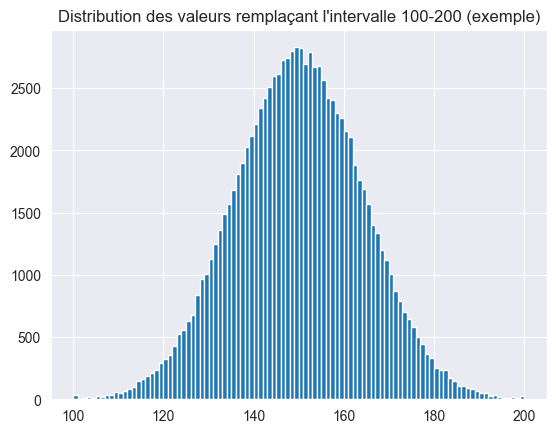

In [500]:
def replace_interval(val):
    if '-' in str(val):
        bounds = val.split('-')
        lower_bound = float(bounds[0])
        upper_bound = float(bounds[1])
        to_ret = np.random.normal(loc=(lower_bound + upper_bound) / 2, scale=(upper_bound - lower_bound) / 7)
        if to_ret < lower_bound:
            to_ret = lower_bound
        if to_ret > upper_bound:
            to_ret = upper_bound
        return to_ret
    else:
        return float(val)
    
test =[replace_interval("100-200") for i in range(100000)]
plt.hist(test, bins=100)
plt.title("Distribution des valeurs remplaçant l'intervalle 100-200 (exemple)")
plt.show()

In [501]:
df_common.loc[:, "Interpass_temp"] = df_common["Interpass_temp"].apply(replace_interval).astype(float)
df_common["Interpass_temp"] = df_common["Interpass_temp"].astype(float)
df_common["Interpass_temp"].describe()

count    1652.000000
mean      204.199803
std        39.375005
min        20.000000
25%       200.000000
50%       200.000000
75%       200.000000
max       300.000000
Name: Interpass_temp, dtype: float64

### Gestion des colonnes AC_DC et Electrode_polarity 

In [502]:
df_common['AC_DC'].unique(), df_common['Electrode_polarity'].unique()

(array(['DC', 'AC', nan], dtype=object),
 array(['+', '0', '-', nan], dtype=object))

<Axes: >

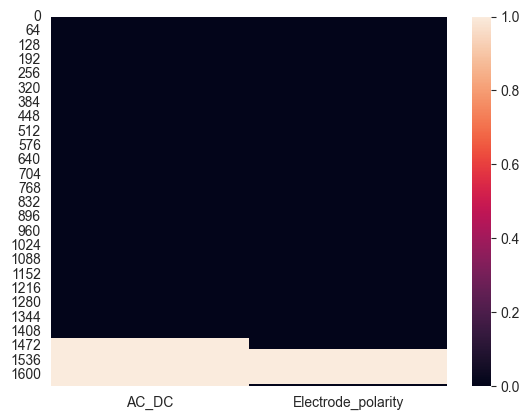

In [503]:
sns.heatmap(df_common[['AC_DC', 'Electrode_polarity']].isna())

In [504]:
df_common[['AC_DC', 'Electrode_polarity']].describe()

,AC_DC,Electrode_polarity
count,1437,1496
unique,2,3
top,DC,+
freq,1395,1451


Les colonnes sont quasiment constantes : DC apparaît 97% du temps et + apparaît 96% du temps. 

On va tester un imputing avec des modèles robustes au problème de déséquilibre de classe (Arbres).

#### Imputing AC_DC 

In [505]:
# import Kfold, RandomForestClassifier, XGBoostClassifier, AdaBoostClassifier

from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix

# Pas besoin de scaler les données pour les modèles d'arbres

full = df_common[list(set(df_common.columns) - set(['Electrode_polarity']))].copy()
full.dropna(inplace=True)

cols = list(set(full.columns) - set(['AC_DC', 'Electrode_polarity', 'Current', 'Voltage'])) # On enlève Current et Voltage car nan

X = full[cols]
y = full['AC_DC']

In [506]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME')
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print((model.predict(X_test) == y_test).sum(), "predictions correctes sur", len(y_test))
    print(f"Fold accuracy: {score:.2%}")
    # matric confusionn
    print(confusion_matrix(y_test, model.predict(X_test)))

C:\Users\gael-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\gael-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


267 predictions correctes sur 267
Fold accuracy: 100.00%
[[  8   0]
 [  0 259]]
267 predictions correctes sur 267
Fold accuracy: 100.00%
[[  9   0]
 [  0 258]]


C:\Users\gael-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\gael-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


266 predictions correctes sur 266
Fold accuracy: 100.00%
[[  4   0]
 [  0 262]]
266 predictions correctes sur 266
Fold accuracy: 100.00%
[[ 11   0]
 [  0 255]]
266 predictions correctes sur 266
Fold accuracy: 100.00%
[[ 10   0]
 [  0 256]]


C:\Users\gael-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


On a de très bons résultats avec le AdaBoostClassifier, on peut facilement remplacer les valeurs manquantes. 

Résultat peut être trop bon --> voir s'il n'y a pas une merde mais ça a l'air ok

In [507]:
# Imputing AC_DC
model.fit(X, y)
df_common.loc[df_common['AC_DC'].isna(), 'AC_DC'] = model.predict(df_common.loc[df_common['AC_DC'].isna(), cols])

C:\Users\gael-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


#### Imputing Electrode_polarity

In [508]:
full = df_common[list(set(df_common.columns) - set(['AC_DC']))].copy()
full.dropna(inplace=True)

cols = list(set(full.columns) - set(['AC_DC', 'Electrode_polarity', 'Current', 'Voltage'])) # On enlève Current et Voltage car nan

X = full[cols]
y = full['Electrode_polarity']

In [509]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME')
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print((model.predict(X_test) == y_test).sum(), "predictions correctes sur", len(y_test))
    print(f"Fold accuracy: {score:.2%}")
    # matric confusionn
    print(confusion_matrix(y_test, model.predict(X_test)))

278 predictions correctes sur 279
Fold accuracy: 99.64%
[[268   0   0]
 [  0   1   0]
 [  1   0   9]]


C:\Users\gael-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\gael-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


278 predictions correctes sur 278
Fold accuracy: 100.00%
[[270   0   0]
 [  0   3   0]
 [  0   0   5]]
276 predictions correctes sur 278
Fold accuracy: 99.28%
[[269   0   0]
 [  2   0   0]
 [  0   0   7]]


C:\Users\gael-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\gael-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


278 predictions correctes sur 278
Fold accuracy: 100.00%
[[268   0   0]
 [  0   1   0]
 [  0   0   9]]
278 predictions correctes sur 278
Fold accuracy: 100.00%
[[271   0]
 [  0   7]]


C:\Users\gael-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Ici aussi les résultats ont l'air très bon. Les modèles n'ignorent pas une des classe. On peut l'utiliser.

In [510]:
# Imputing Electrode_polarity
model.fit(X, y)
df_common.loc[df_common['Electrode_polarity'].isna(), 'Electrode_polarity'] = model.predict(df_common.loc[df_common['Electrode_polarity'].isna(), cols])

C:\Users\gael-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


In [511]:
# AC_DC est catégorielle, on fait du one-hot encoding
df_common = pd.get_dummies(df_common, columns=['AC_DC'], prefix='AC_DC', drop_first=False, dtype=int)

# Electrode_polarity est catégorielle, on fait du one-hot encoding
df_common = pd.get_dummies(df_common, columns=['Electrode_polarity'], prefix='Electrode_polarity', drop_first=False, dtype=int)

#### Gestion des nan dans les colonnes numériques

In [512]:
df_common.isna().sum()

C                         0
Si                        0
Mn                        0
S                         0
P                         0
Ni                        0
Cr                        0
Mo                        0
V                         0
Cu                        0
Co                        0
W                         0
O                         0
Ti                        0
N                         0
Al                        0
B                         0
Nb                        0
Sn                        0
As                        0
Sb                        0
Current                 248
Voltage                 248
Heat_input                0
Interpass_temp            0
PWHT_temp                13
PWHT_time                13
Weld_type_FCA             0
Weld_type_GMAA            0
Weld_type_GTAA            0
Weld_type_MMA             0
Weld_type_NGGMA           0
Weld_type_NGSAW           0
Weld_type_SA              0
Weld_type_SAA             0
Weld_type_ShMA      

In [513]:
cols_na = ['Current', 'Voltage', 'PWHT_temp', 'PWHT_time']

df_common[cols_na].describe()

,Current,Voltage,PWHT_temp,PWHT_time
count,1404.000000,1404.000000,1639.000000,1639.000000
mean,283.843661,27.607379,304.674192,5.049652
std,192.560955,12.555629,285.498003,6.096034
min,115.000000,11.500000,0.000000,0.000000
25%,170.000000,21.000000,0.000000,0.000000
50%,170.000000,21.000000,250.000000,2.000000
75%,300.000000,30.000000,580.000000,10.000000
max,900.000000,75.360000,760.000000,24.000000


In [514]:
df_common[cols_na]

,Current,Voltage,PWHT_temp,PWHT_time
0,170.0,21.0,250.0,14.0
1,170.0,21.0,0.0,0.0
2,170.0,21.0,580.0,2.0
3,170.0,21.0,250.0,14.0
4,170.0,21.0,0.0,0.0
...,...,...,...,...
1647,450.0,30.0,760.0,2.0
1648,450.0,30.0,760.0,2.0
1649,450.0,30.0,760.0,2.0
1650,450.0,30.0,760.0,2.0


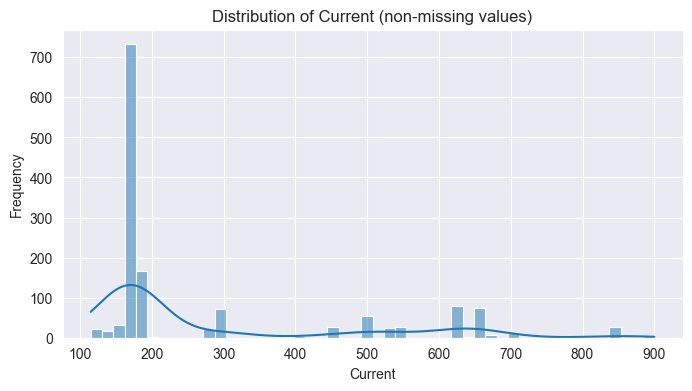

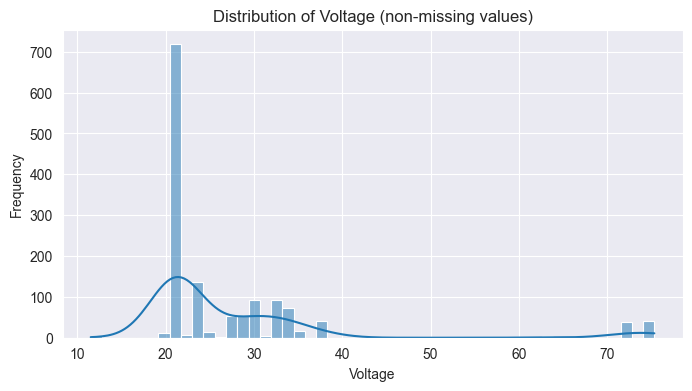

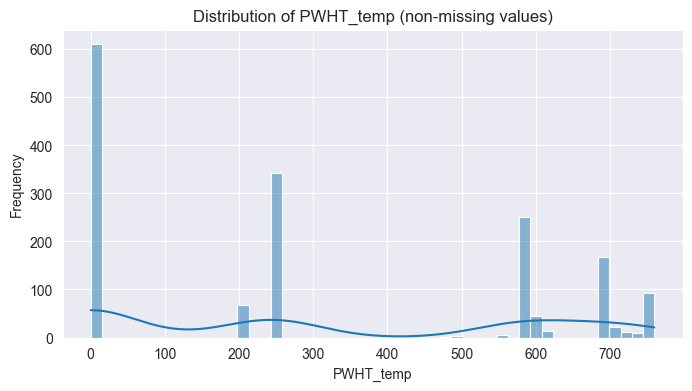

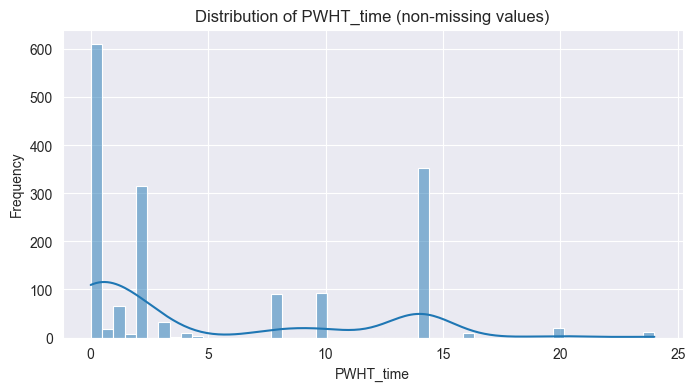

In [515]:
# Plot of the distributions of the columns with missing values
for col in cols_na:
    plt.figure(figsize=(8,4))
    sns.histplot(df_common[col].dropna(), bins=50, kde=True)
    plt.title(f'Distribution of {col} (non-missing values)')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

Les distributions sont très disparates. On va essayer de remplacer les valeurs manquantes avec les mêmes méthodes que précédemment.

In [516]:
from sklearn.ensemble import AdaBoostRegressor

models = {}

for col in cols_na:
    full = df_common[list(set(df_common.columns) - (set(cols_na) - {col}))].copy()
    full.dropna(inplace=True)

    cols = list(set(full.columns) - set(cols_na)) 

    X = full[cols]
    y = full[col]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = AdaBoostRegressor(n_estimators=100, random_state=42)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        #score = model.score(X_test, y_test)
        score = np.sqrt(np.mean((model.predict(X_test) - y_test) ** 2))
        print(f"Fold RMSE for {col}: {score}")
        print(f"Fold R2 for {col}: {model.score(X_test, y_test):.2%}\n")
    
    print("_"*40+"\n")
    model.fit(X, y)
    models[col] = (model, cols)

Fold RMSE for Current: 21.306442981445922
Fold R2 for Current: 98.82%

Fold RMSE for Current: 21.884088009565147
Fold R2 for Current: 98.72%

Fold RMSE for Current: 18.203634023722238
Fold R2 for Current: 99.15%

Fold RMSE for Current: 20.856736973341782
Fold R2 for Current: 98.80%

Fold RMSE for Current: 20.55643495783139
Fold R2 for Current: 98.77%

________________________________________

Fold RMSE for Voltage: 3.823803928653212
Fold R2 for Voltage: 91.37%

Fold RMSE for Voltage: 2.5112888195394873
Fold R2 for Voltage: 96.36%

Fold RMSE for Voltage: 2.703129532048477
Fold R2 for Voltage: 95.33%

Fold RMSE for Voltage: 3.8552907595397
Fold R2 for Voltage: 90.05%

Fold RMSE for Voltage: 2.8448535138659348
Fold R2 for Voltage: 94.17%

________________________________________

Fold RMSE for PWHT_temp: 210.54222151786234
Fold R2 for PWHT_temp: 46.65%

Fold RMSE for PWHT_temp: 197.53669106205746
Fold R2 for PWHT_temp: 53.66%

Fold RMSE for PWHT_temp: 189.29753269135693
Fold R2 for PWHT_t

Pour les variables Current et Voltage, le modèle est performant donc on va pouvoir compléter les valeurs manquantes. Pour les colonnes PWHT_temp et PWHT_time les résultats sont bien moins bon et les résultats varient beaucoup d'un plie à l'autre, montrant une grande variance dans les résultats. Etant donné qu'il n'y a que peu de valeurs manquantes (13) on va tout de même les compléter avec le modèle mais ces variables pourraient ne pas être utilisées à l'avenir. 

In [517]:
# Imputing des colonnes avec les modèles entrainés
for col in cols_na:
    df_common.loc[df_common[col].isna(), col] = models[col][0].predict(df_common.loc[df_common[col].isna(), models[col][1]])

In [518]:
df_common.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   C                     1652 non-null   float64
 1   Si                    1652 non-null   float64
 2   Mn                    1652 non-null   float64
 3   S                     1652 non-null   float64
 4   P                     1652 non-null   float64
 5   Ni                    1652 non-null   float64
 6   Cr                    1652 non-null   float64
 7   Mo                    1652 non-null   float64
 8   V                     1652 non-null   float64
 9   Cu                    1652 non-null   float64
 10  Co                    1652 non-null   float64
 11  W                     1652 non-null   float64
 12  O                     1652 non-null   float64
 13  Ti                    1652 non-null   float64
 14  N                     1652 non-null   float64
 15  Al                   

On a maintenant uniquement des valeurs numériques et plus aucun nan dans les colonnes communes au 2 datasets. On va pouvoir commencer à faire l'analyse des colonnes spécifiques. 

# Gestion du dataset 1

In [519]:
import os

dataset_1_plot_path = "../outputs/dataset_1/"
"""Chemin disque pour la sauvegarde des graphiques liés au dataset 1"""
df_1_targets: list[str] = first_dataset_cols
"""Propriétés cibles que l'on veut compléter dans cette analyse"""
df_1_properties: list[str]  = df_common.columns.to_list()

os.makedirs(dataset_1_plot_path, exist_ok=True)

first_dataset_cols # colonnes spécifiques au premier dataset

['Yield_strength', 'UTS', 'Elongation', 'Reduction_area']

In [520]:
df_1_properties

['C',
 'Si',
 'Mn',
 'S',
 'P',
 'Ni',
 'Cr',
 'Mo',
 'V',
 'Cu',
 'Co',
 'W',
 'O',
 'Ti',
 'N',
 'Al',
 'B',
 'Nb',
 'Sn',
 'As',
 'Sb',
 'Current',
 'Voltage',
 'Heat_input',
 'Interpass_temp',
 'PWHT_temp',
 'PWHT_time',
 'Weld_type_FCA',
 'Weld_type_GMAA',
 'Weld_type_GTAA',
 'Weld_type_MMA',
 'Weld_type_NGGMA',
 'Weld_type_NGSAW',
 'Weld_type_SA',
 'Weld_type_SAA',
 'Weld_type_ShMA',
 'Weld_type_TSA',
 'AC_DC_AC',
 'AC_DC_DC',
 'Electrode_polarity_+',
 'Electrode_polarity_-',
 'Electrode_polarity_0']

In [521]:
# Création du dataset avec df_common pour récupérer toutes les valeurs des éléments chimiques
df_1 = pd.concat([df_common, df_first[first_dataset_cols]], axis=1)
"""Dataset complet contenant les colonnes 'df_1_targets' et 'df_1_properties'"""
df_1

,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,Weld_type_TSA,AC_DC_AC,AC_DC_DC,Electrode_polarity_+,Electrode_polarity_-,Electrode_polarity_0,Yield_strength,UTS,Elongation,Reduction_area
0,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,1,1,0,0,392.0,466.0,31.9,80.6
1,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,1,1,0,0,NaN,NaN,NaN,NaN
2,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,1,1,0,0,370.0,456.0,35.2,80.6
3,0.037,0.31,1.03,0.007,0.014,0.00,0.0,0.00,0.00,0.0,...,0,0,1,1,0,0,413.0,498.0,31.2,80.6
4,0.037,0.31,1.03,0.007,0.014,0.00,0.0,0.00,0.00,0.0,...,0,0,1,1,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.6,0.98,0.18,0.0,...,0,0,1,1,0,0,834.0,NaN,NaN,NaN
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.4,0.94,0.19,0.0,...,0,0,1,1,0,0,822.0,NaN,NaN,NaN
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.2,0.94,0.02,0.0,...,0,0,1,1,0,0,660.0,NaN,NaN,NaN
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.4,0.97,0.17,0.0,...,0,0,1,1,0,0,832.0,NaN,NaN,NaN


In [522]:
# Vérification de la cohérence de la taille du dataset concaténé
print(f"Taille du dataset 1         : {df_first.shape}")
print(f"Taille du dataset commun    : {df_common.shape}")
print(f"Taille du dataset 1 complet : {df_1.shape}")
assert df_1.shape[0] == df_first.shape[0]
# Si l'assert bloque, alors la concaténation à rajouter des lignes, ce qui n'est pas souhaitable : on veut les colonnes

Taille du dataset 1         : (1652, 34)
Taille du dataset commun    : (1652, 42)
Taille du dataset 1 complet : (1652, 46)


# Recherche de corrélation (propriétés physiques)

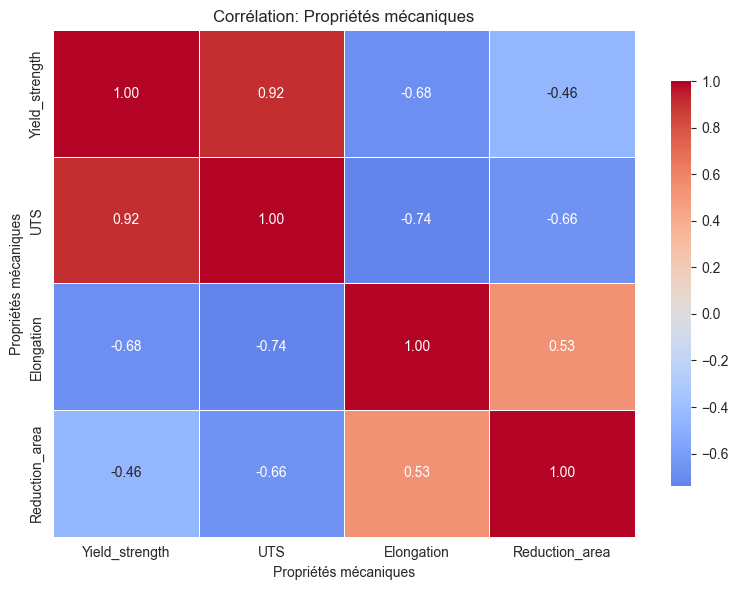

In [523]:
# Analyse de corrélations potientielles entre les propriétés mécaniques
targets_corr = df_1[df_1_targets].corr()

# Affichage de matrices de corrélation entre les différentes propriétés mécaniques
plt.figure(figsize=(8, 6))
sns.heatmap(targets_corr,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Corrélation: Propriétés mécaniques')
plt.xlabel('Propriétés mécaniques')
plt.ylabel('Propriétés mécaniques')
plt.tight_layout()
plt.show()

On constate de fortes corrélation entre les propriétés mécaniques (deux à deux) :
- UTS' et 'Yield_strength
- Elongation et Reduction_area

Cela correspond à de la résistance et de la flexibilité.
On peut en apprendre plus en graphant leurs distributions

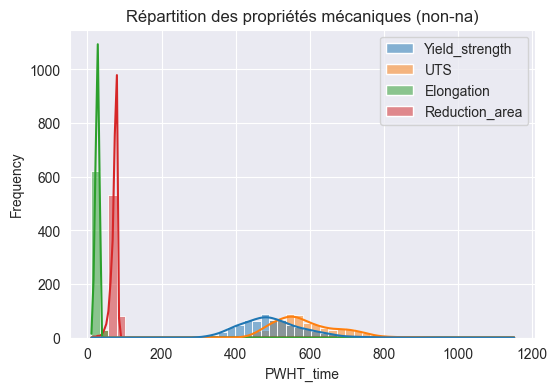

In [524]:
plt.figure(figsize=(6,4))
sns.histplot(df_1[df_1_targets].dropna(), bins=50, kde=True)
plt.title(f'Répartition des propriétés mécaniques (non-na)')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.show()

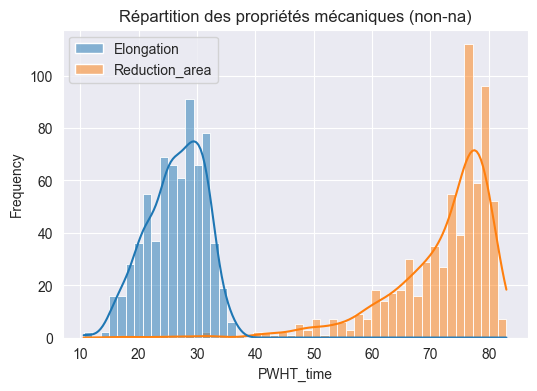

In [525]:
plt.figure(figsize=(6,4))
sns.histplot(df_1[['Elongation', 'Reduction_area']].dropna(), bins=50, kde=True)
plt.title(f'Répartition des propriétés mécaniques (non-na)')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.show()

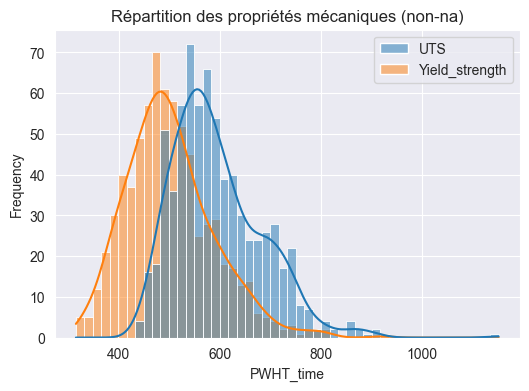

In [526]:
plt.figure(figsize=(6,4))
sns.histplot(df_1[['UTS', 'Yield_strength']].dropna(), bins=50, kde=True)
plt.title(f'Répartition des propriétés mécaniques (non-na)')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.show()

Quand on rapproche les distributions des propriétés physiques deux à deux, on se rend compte qu'il existe une nette ressemblance, même au niveau de l'échelle. Elles sont deux à deux des candidates idéales pour l'imputation, à condition qu'elles ne soient pas manquantes en même temps.

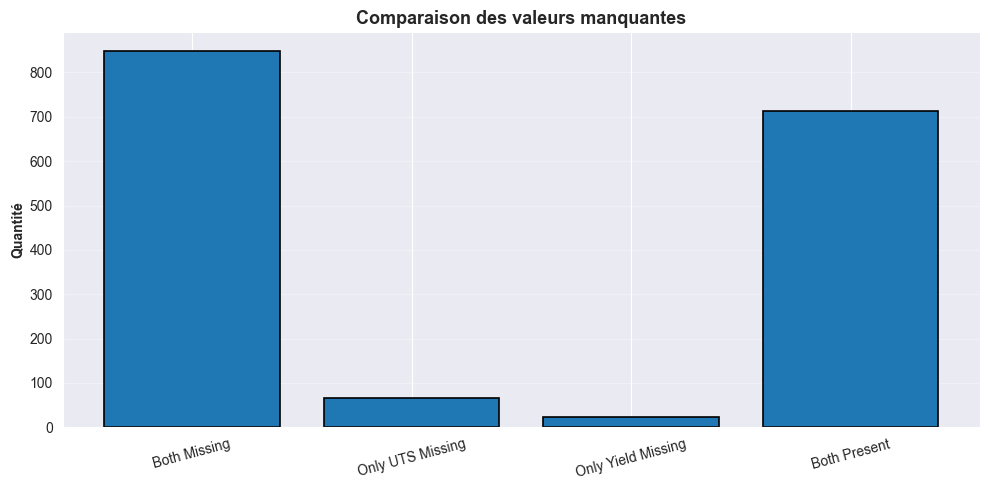

In [527]:
uts_missing = df_1['UTS'].isna()
yield_missing = df_1['Yield_strength'].isna()

cases = {
    'Both Missing'      : (uts_missing & yield_missing).sum(),
    'Only UTS Missing'  : (uts_missing & ~yield_missing).sum(),
    'Only Yield Missing': (~uts_missing & yield_missing).sum(),
    'Both Present'      : (~uts_missing & ~yield_missing).sum()
}

plt.figure(figsize=(10, 5))
plt.bar(cases.keys(), cases.values(), edgecolor='black', linewidth=1.2)
plt.ylabel('Quantité', fontweight='bold')
plt.title('Comparaison des valeurs manquantes', fontweight='bold', fontsize=13)
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


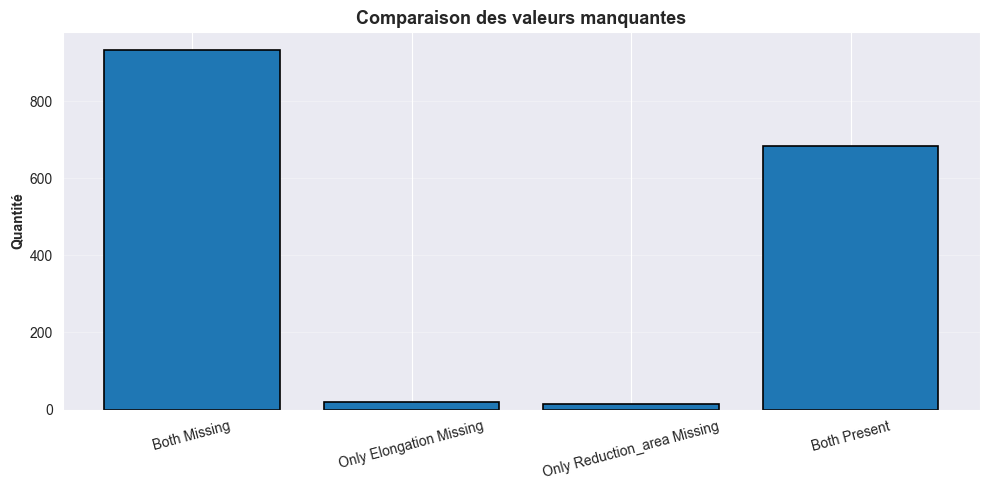

In [528]:
Elongation_missing = df_1['Elongation'].isna()
Reduction_area_missing = df_1['Reduction_area'].isna()

cases = {
    'Both Missing'               : (Elongation_missing & Reduction_area_missing).sum(),
    'Only Elongation Missing'    : (Elongation_missing & ~Reduction_area_missing).sum(),
    'Only Reduction_area Missing': (~Elongation_missing & Reduction_area_missing).sum(),
    'Both Present'               : (~Elongation_missing & ~Reduction_area_missing).sum()
}

plt.figure(figsize=(10, 5))
plt.bar(cases.keys(), cases.values(), edgecolor='black', linewidth=1.2)
plt.ylabel('Quantité', fontweight='bold')
plt.title('Comparaison des valeurs manquantes', fontweight='bold', fontsize=13)
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Malheureusement, la majorité des cas manquants sont présents sur les deux valeurs à la fois, limitant la possibilité d'utiliser notre plus forte corrélation pour cette tâche.

Seconde vue de la corrélation des valeures manquantes pour les propriétés physiques (sous forme de heatmap)

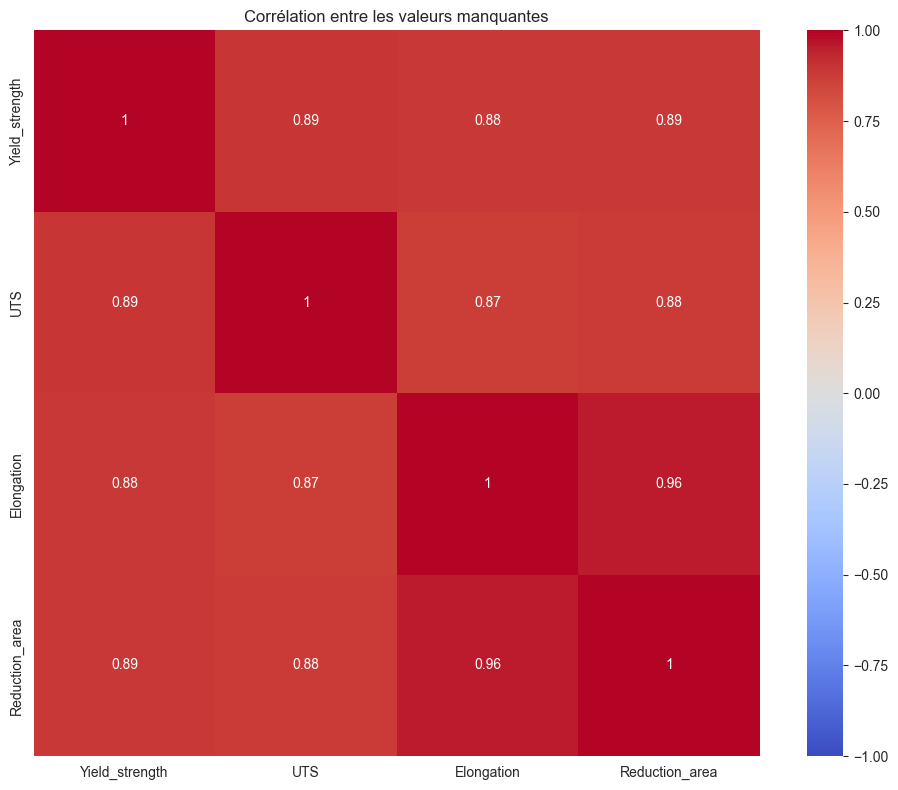

In [529]:
missing_correlation = df_1[df_1_targets].isnull().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(missing_correlation, annot=True, cmap='coolwarm', center=0,
            vmin=-1, vmax=1, square=True)
plt.title('Corrélation entre les valeurs manquantes')
plt.tight_layout()
plt.show()

cols_with_na = df_1.columns[df_1.isnull().any()].tolist()
if len(cols_with_na) > 1:
    for i, col1 in enumerate(cols_with_na):
        for col2 in cols_with_na[i+1:]:
            contingency = pd.crosstab(df_1[col1].isnull(),
                                     df_1[col2].isnull(),
                                     margins=True)

In [530]:
# Correctif des données pour la colonne 'Interpass_temp'
def replace_interval_mean(val):
    if '-' in str(val):
        bounds = val.split('-')
        lower_bound = float(bounds[0])
        upper_bound = float(bounds[1])
        return (lower_bound + upper_bound) / 2
    else:
        return float(val)

# df_1.loc[:, 'Interpass_temp'] = df_1['Interpass_temp'].apply(replace_interval_mean).astype(float)

# Recherche de nouvelles corrélations

In [531]:
df_1_targets_to_properties_correlation_matrix = df_1[df_1_targets + df_1_properties].corr()
"""La matrice de corrélation entre les targets et properties du dataset 1"""
top_n = 30

In [532]:
def get_top_correlations(corr_matrix, target_cols, property_cols, top_n=30):
    """
    Extrait les top N corrélations entre targets et properties

    """
    # Assurer que target_cols est une liste
    if isinstance(target_cols, str):
        target_cols = [target_cols]

    corr_targets_properties = corr_matrix.loc[target_cols, property_cols]
    corr_flat = corr_targets_properties.stack()
    top_corr = corr_flat.abs().sort_values(ascending=False).head(top_n)
    top_corr_values = corr_flat[top_corr.index]

    return top_corr_values

In [533]:
def plot_correlation_barh(corr_values, top_n, title="Corrélations entre Targets vs Properties"):
    """
        Plot un graphique horizontal des corrélations
    """
    plt.figure(figsize=(10, 6))
    colors = ['red' if x < 0 else 'steelblue' for x in corr_values]
    corr_values.plot(kind='barh', color=colors)
    plt.title(f"Top {top_n} {title}")
    plt.xlabel('Correlation')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [534]:
"""
corr_targets_properties = df_1_targets_to_properties_correlation_matrix.loc[df_1_targets, df_1_properties]

corr_flat = corr_targets_properties.stack()
top_corr = corr_flat.abs().sort_values(ascending=False).head(top_n)

top_corr_values = corr_flat[top_corr.index]

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'steelblue' for x in top_corr_values]
top_corr_values.plot(kind='barh', color=colors)
plt.title(f"Top {top_n} des corrélations entre Targets vs Properties (dataset 1)")
plt.xlabel('Correlation')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("Corrélations les plus fortes :")
print(top_corr_values)
"""

'\ncorr_targets_properties = df_1_targets_to_properties_correlation_matrix.loc[df_1_targets, df_1_properties]\n\ncorr_flat = corr_targets_properties.stack()\ntop_corr = corr_flat.abs().sort_values(ascending=False).head(top_n)\n\ntop_corr_values = corr_flat[top_corr.index]\n\nplt.figure(figsize=(10, 6))\ncolors = [\'red\' if x < 0 else \'steelblue\' for x in top_corr_values]\ntop_corr_values.plot(kind=\'barh\', color=colors)\nplt.title(f"Top {top_n} des corrélations entre Targets vs Properties (dataset 1)")\nplt.xlabel(\'Correlation\')\nplt.axvline(x=0, color=\'black\', linestyle=\'-\', linewidth=0.5)\nplt.grid(axis=\'x\', alpha=0.3)\nplt.tight_layout()\nplt.show()\n\nprint("Corrélations les plus fortes :")\nprint(top_corr_values)\n'

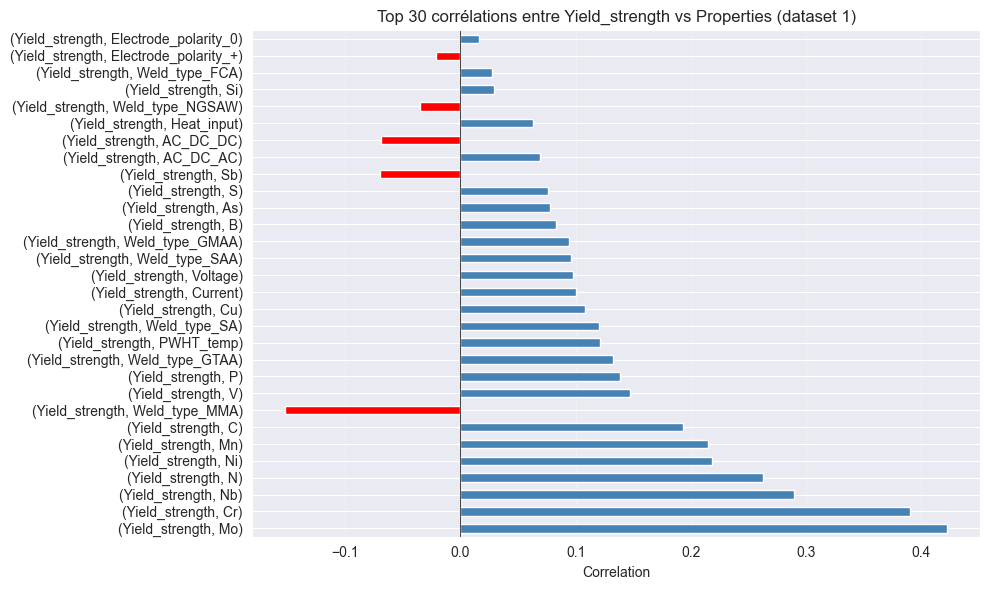

Corrélations les plus fortes pour Yield_strength :
Yield_strength  Mo                      0.422291
                Cr                      0.389984
                Nb                      0.289475
                N                       0.262311
                Ni                      0.218327
                Mn                      0.214946
                C                       0.192990
                Weld_type_MMA          -0.151842
                V                       0.147486
                P                       0.138837
                Weld_type_GTAA          0.132244
                PWHT_temp               0.120882
                Weld_type_SA            0.120547
                Cu                      0.108544
                Current                 0.100234
                Voltage                 0.097692
                Weld_type_SAA           0.095884
                Weld_type_GMAA          0.094530
                B                       0.083419
                As

In [535]:
c = 'Yield_strength'
top_corr_values = get_top_correlations(
    df_1_targets_to_properties_correlation_matrix,
    c,
    df_1_properties,
    top_n
)
plot_correlation_barh(top_corr_values, top_n, f"corrélations entre {c} vs Properties (dataset 1)")

print(f"Corrélations les plus fortes pour {c} :")
print(top_corr_values)

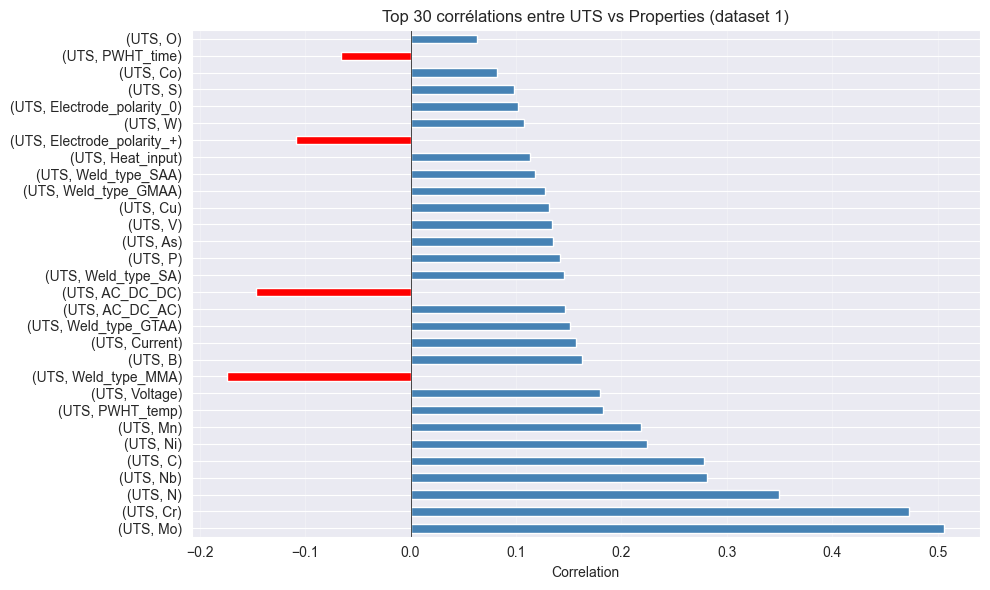

Corrélations les plus fortes pour UTS :
UTS  Mo                      0.506292
     Cr                      0.472925
     N                       0.349861
     Nb                      0.281197
     C                       0.278184
     Ni                      0.224083
     Mn                      0.219040
     PWHT_temp               0.182308
     Voltage                 0.179524
     Weld_type_MMA          -0.173705
     B                       0.162450
     Current                 0.157017
     Weld_type_GTAA          0.151153
     AC_DC_AC                0.146578
     AC_DC_DC               -0.146578
     Weld_type_SA            0.145987
     P                       0.141627
     As                      0.134872
     V                       0.133910
     Cu                      0.131255
     Weld_type_GMAA          0.127817
     Weld_type_SAA           0.117816
     Heat_input              0.113760
     Electrode_polarity_+   -0.109016
     W                       0.107726
     Elect

In [536]:
c = 'UTS'
top_corr_values = get_top_correlations(
    df_1_targets_to_properties_correlation_matrix,
    c,
    df_1_properties,
    top_n
)
plot_correlation_barh(top_corr_values, top_n, f"corrélations entre {c} vs Properties (dataset 1)")

print(f"Corrélations les plus fortes pour {c} :")
print(top_corr_values)

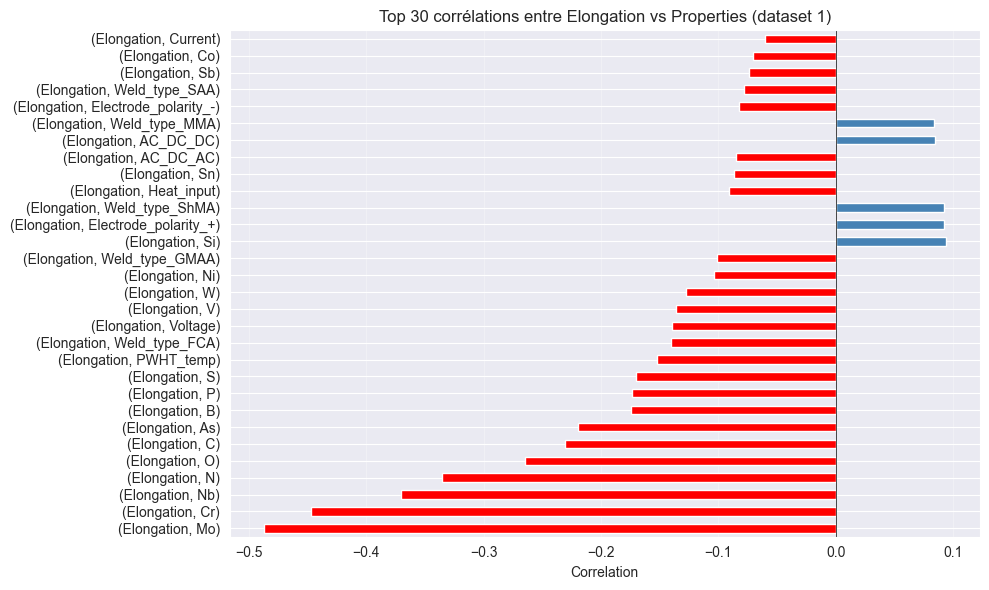

Corrélations les plus fortes pour Elongation :
Elongation  Mo                     -0.487221
            Cr                     -0.447283
            Nb                     -0.370144
            N                      -0.335688
            O                      -0.264541
            C                      -0.230813
            As                     -0.219130
            B                      -0.174048
            P                      -0.173217
            S                      -0.169694
            PWHT_temp              -0.152391
            Weld_type_FCA          -0.140657
            Voltage                -0.139803
            V                      -0.135781
            W                      -0.127392
            Ni                     -0.103413
            Weld_type_GMAA         -0.101117
            Si                      0.093980
            Electrode_polarity_+    0.092287
            Weld_type_ShMA          0.092133
            Heat_input             -0.090831
        

In [537]:
c = 'Elongation'
top_corr_values = get_top_correlations(
    df_1_targets_to_properties_correlation_matrix,
    c,
    df_1_properties,
    top_n
)
plot_correlation_barh(top_corr_values, top_n, f"corrélations entre {c} vs Properties (dataset 1)")

print(f"Corrélations les plus fortes pour {c} :")
print(top_corr_values)

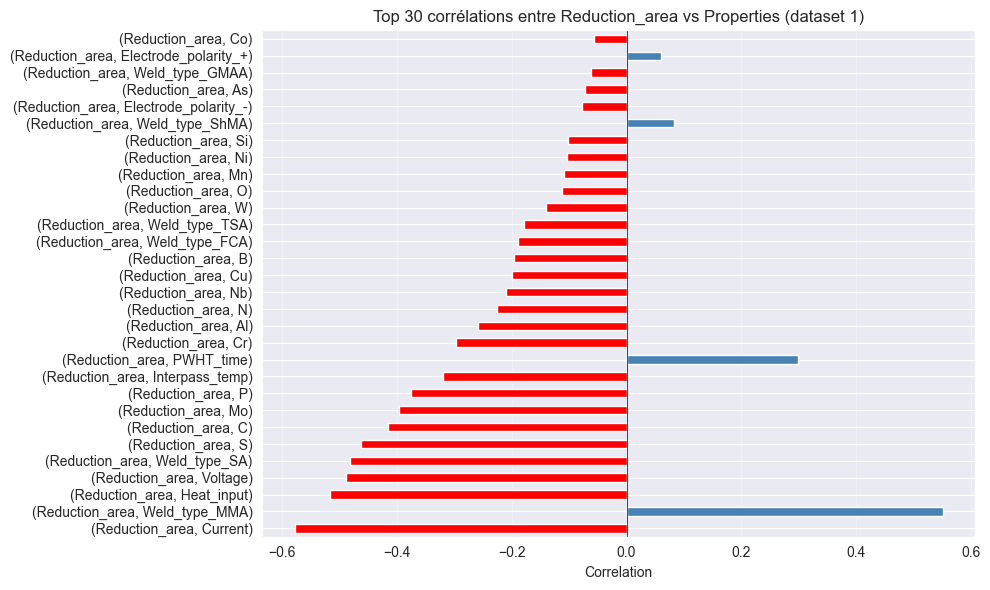

Corrélations les plus fortes pour Reduction_area :
Reduction_area  Current                -0.578513
                Weld_type_MMA           0.551537
                Heat_input             -0.516022
                Voltage                -0.488388
                Weld_type_SA           -0.481495
                S                      -0.462232
                C                      -0.416629
                Mo                     -0.395794
                P                      -0.375229
                Interpass_temp         -0.320705
                PWHT_time               0.299559
                Cr                     -0.297538
                Al                     -0.259219
                N                      -0.226125
                Nb                     -0.209318
                Cu                     -0.199895
                B                      -0.195636
                Weld_type_FCA          -0.188604
                Weld_type_TSA          -0.178707
                W 

In [538]:
c = 'Reduction_area'
top_corr_values = get_top_correlations(
    df_1_targets_to_properties_correlation_matrix,
    c,
    df_1_properties,
    top_n
)
plot_correlation_barh(top_corr_values, top_n, f"corrélations entre {c} vs Properties (dataset 1)")

print(f"Corrélations les plus fortes pour {c} :")
print(top_corr_values)

# Tests d'algorithmes de prédictions pour les valeurs mécaniques manquantes du dataset 1 à partir des propriétés de df_common

# Grid search pour les regresseurs - recherche d'un regresseur optimal paramétré
J'ai déjà exécuté la search une fois et retiré des paramètres des grid pour des raisons de performances

In [539]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

def optimize_regressor(data, properties, targets, param_grid, model_class, model_name) -> dict:
    """
    Optimise un modèle de régression pour chaque target via GridSearchCV
    :param
    data : pd.DataFrame - Dataset complet avec features et targets
    properties : list -Noms des colonnes features
    targets : list - Noms des colonnes targets
    param_grid : dict - Grille de paramètres pour GridSearchCV
    model_class : class -Classe du modèle (AdaBoostRegressor, XGBRegressor, etc.)
    model_name : str - Nom du modèle pour affichage
    :return
        dict : Meilleurs modèles par target
    """
    best_models = {}

    for target in targets:
        print(f"\nOptimisation {model_name} pour {target}...")

        train_mask = data[target].notna()
        X_train = data.loc[train_mask, properties]
        y_train = data.loc[train_mask, target]

        grid_search = GridSearchCV(
            estimator=model_class(random_state=42),
            param_grid=param_grid,
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X_train, y_train)

        print(f"{target}: R² = {grid_search.best_score_:.3f} => {grid_search.best_params_}")

        best_models[target] = grid_search.best_estimator_

    return best_models

In [540]:
data_optimized = df_1[df_1_properties + df_1_targets].copy()
"""Le dataset utilisé pour entraîner les regresseurs puis où on imputeras les valeurs manquantes du dataset 1"""

'Le dataset utilisé pour entraîner les regresseurs puis où on imputeras les valeurs manquantes du dataset 1'

# AdaBoost

In [541]:
ada_param_grid = {
    'n_estimators': [75, 100, 150, 200],
    'learning_rate': [0.1, 0.2, 0.5, 1.0],
    'loss': ['square', 'exponential']
}

ada_best_models = optimize_regressor(
    data=data_optimized,
    properties=df_1_properties,
    targets=df_1_targets,
    param_grid=ada_param_grid,
    model_class=AdaBoostRegressor,
    model_name="AdaBoost"
)


Optimisation AdaBoost pour Yield_strength...
Yield_strength: R² = 0.419 => {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 200}

Optimisation AdaBoost pour UTS...
UTS: R² = 0.458 => {'learning_rate': 0.5, 'loss': 'square', 'n_estimators': 150}

Optimisation AdaBoost pour Elongation...
Elongation: R² = 0.298 => {'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 200}

Optimisation AdaBoost pour Reduction_area...
Reduction_area: R² = 0.115 => {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 150}



Optimisation AdaBoost pour Yield_strength...
Yield_strength: R² = 0.413 => {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 200}

Optimisation AdaBoost pour UTS...
UTS: R² = 0.469 => {'learning_rate': 0.5, 'loss': 'square', 'n_estimators': 150}

Optimisation AdaBoost pour Elongation...
Elongation: R² = 0.296 => {'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 100}

Optimisation AdaBoost pour Reduction_area...
Reduction_area: R² = 0.112 => {'learning_rate': 0.2, 'loss': 'exponential', 'n_estimators': 75}

# XGBoost
Attention, le temps d'exécution de la cellule est long (style 20 minutes) ! J'ai réduit manuellement les paramètres pour trouver la solution optimal plus vite

In [542]:
xgb_param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [3, 4],
    'learning_rate': [0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8],
    'min_child_weight': [1, 3, 5]
}

xgb_best_models = optimize_regressor(
    data=data_optimized,
    properties=df_1_properties,
    targets=df_1_targets,
    param_grid=xgb_param_grid,
    model_class=xgb.XGBRegressor,
    model_name="XGBoost"
)


Optimisation XGBoost pour Yield_strength...
Yield_strength: R² = 0.586 => {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 1.0}

Optimisation XGBoost pour UTS...
UTS: R² = 0.571 => {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}

Optimisation XGBoost pour Elongation...
Elongation: R² = 0.321 => {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}

Optimisation XGBoost pour Reduction_area...
Reduction_area: R² = 0.288 => {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}



Optimisation XGBoost pour Yield_strength...
Yield_strength: R² = 0.591 => {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 1.0}

Optimisation XGBoost pour UTS...
UTS: R² = 0.566 => {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.9}

Optimisation XGBoost pour Elongation...
Elongation: R² = 0.338 => {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}

Optimisation XGBoost pour Reduction_area...
Reduction_area: R² = 0.341 => {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}

In [543]:
# Imputation par XGBoost (meilleurs résultats)
for target in df_1_targets:
    missing_mask = data_optimized[target].isna()

    if missing_mask.sum() > 0:
        X_missing = data_optimized.loc[missing_mask, df_1_properties]
        predictions = xgb_best_models[target].predict(X_missing)

        data_optimized.loc[missing_mask, target] = predictions

        print(f"{target}: {missing_mask.sum()} valeurs imputées")

print(f"Imputation terminée. Shape: {data_optimized.shape}")
print(f"Valeurs manquantes restantes:\n{data_optimized[df_1_targets].isna().sum()}")

Yield_strength: 872 valeurs imputées
UTS: 914 valeurs imputées
Elongation: 952 valeurs imputées
Reduction_area: 947 valeurs imputées
Imputation terminée. Shape: (1652, 46)
Valeurs manquantes restantes:
Yield_strength    0
UTS               0
Elongation        0
Reduction_area    0
dtype: int64


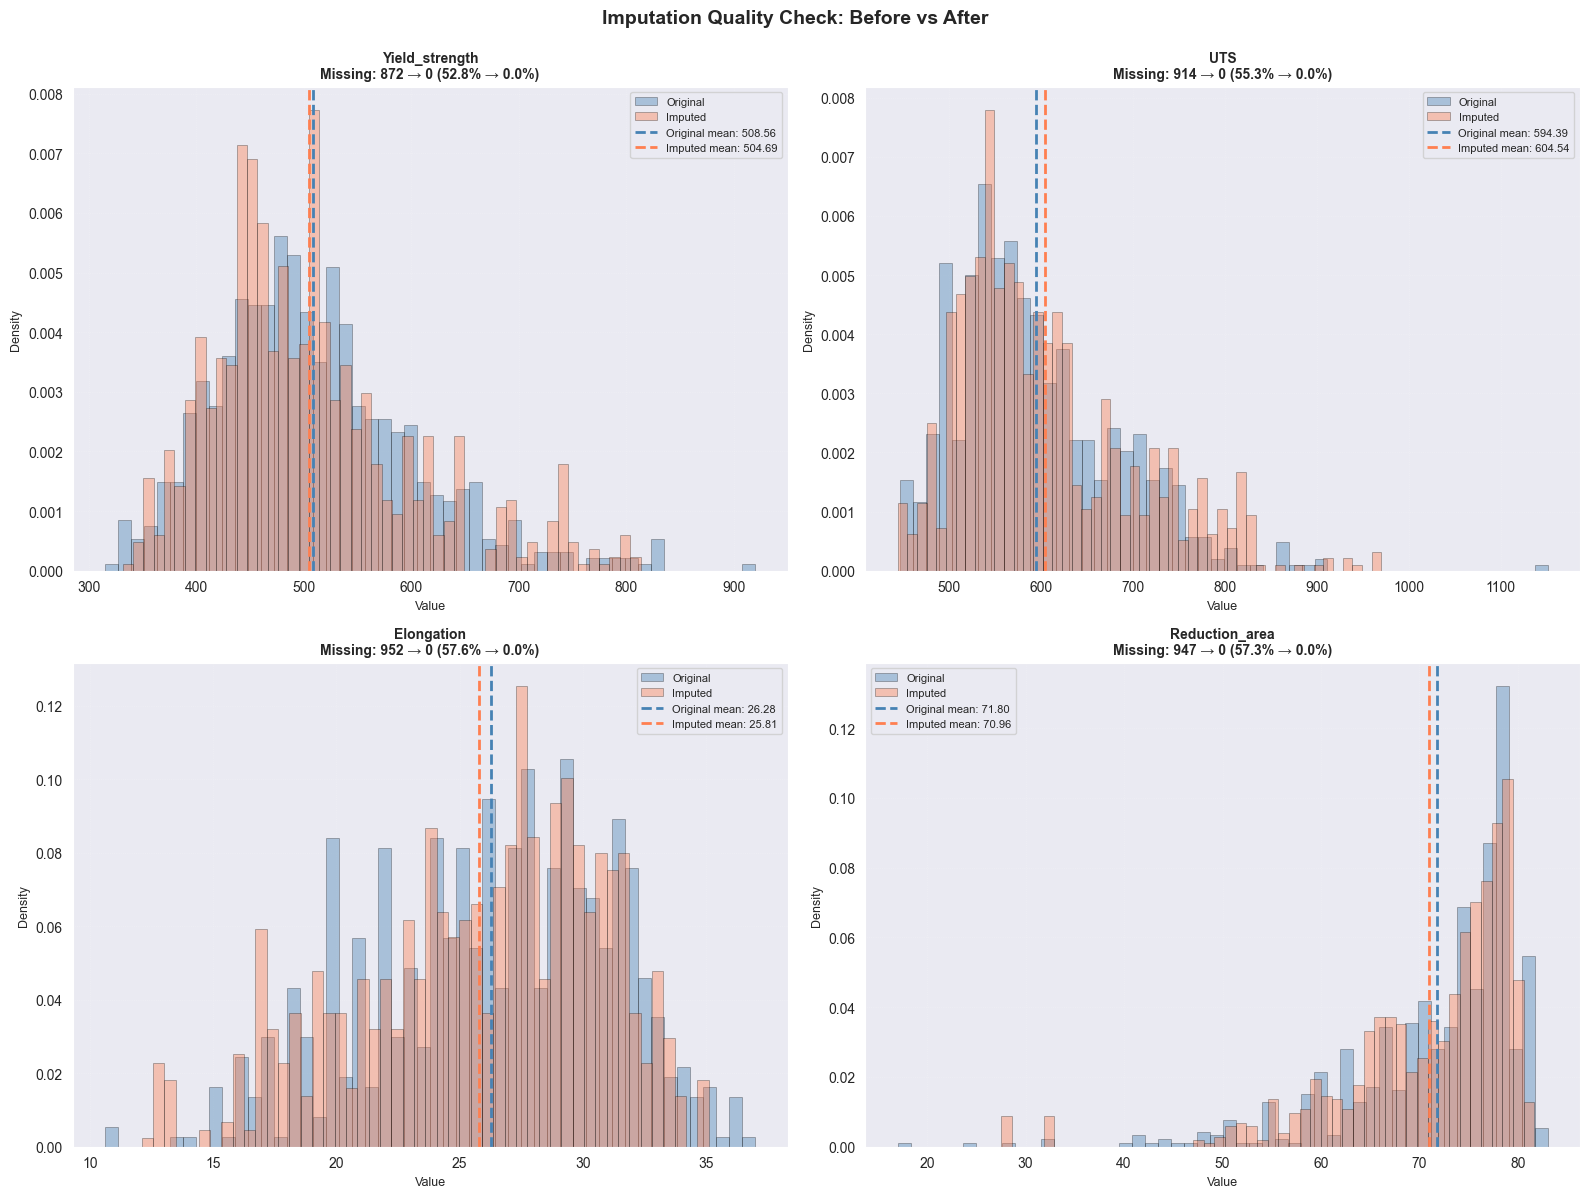

In [544]:
def plot_imputation_comparison(df_before, df_after, target_cols, figsize=(16, 12)):
    """
    Compare les distributions avant/après imputation avec métriques de qualité.

    Args:
        df_before: DataFrame avant imputation
        df_after: DataFrame après imputation
        target_cols: Liste des colonnes cibles à comparer
    """
    n_cols = len(target_cols)
    n_rows = (n_cols + 1) // 2

    fig, axes = plt.subplots(n_rows, 2, figsize=figsize)
    axes = axes.flatten() if n_cols > 1 else [axes]

    for idx, col in enumerate(target_cols):
        ax = axes[idx]

        if col not in df_before.columns or col not in df_after.columns:
            ax.text(0.5, 0.5, f'{col}\nnot found', ha='center', va='center')
            continue

        before_vals = df_before[col].dropna()
        after_vals = df_after[col].dropna()
        imputed_vals = df_after.loc[df_before[col].isna(), col].dropna()

        # Statistiques
        missing_before = df_before[col].isna().sum()
        missing_after = df_after[col].isna().sum()
        n_imputed = len(imputed_vals)

        # Distribution originale (avant imputation)
        ax.hist(before_vals, bins=50, alpha=0.4, label='Original', color='steelblue', density=True, edgecolor='black', linewidth=0.5)

        # Valeurs imputées
        if n_imputed > 0:
            ax.hist(imputed_vals, bins=50, alpha=0.4, label='Imputed', color='coral', density=True, edgecolor='black', linewidth=0.5)

        # Lignes de statistiques
        ax.axvline(before_vals.mean(), color='steelblue', linestyle='--', linewidth=2, label=f'Original mean: {before_vals.mean():.2f}')
        if n_imputed > 0:
            ax.axvline(imputed_vals.mean(), color='coral', linestyle='--', linewidth=2, label=f'Imputed mean: {imputed_vals.mean():.2f}')

        # Titre avec métriques
        title = f'{col}\n'
        title += f'Missing: {missing_before} → {missing_after} '
        title += f'({(missing_before/len(df_before)*100):.1f}% → {(missing_after/len(df_after)*100):.1f}%)'
        ax.set_title(title, fontsize=10, fontweight='bold')

        ax.set_xlabel('Value', fontsize=9)
        ax.set_ylabel('Density', fontsize=9)
        ax.legend(fontsize=8, loc='best')
        ax.grid(alpha=0.3, linestyle=':', linewidth=0.5)

    plt.suptitle('Imputation Quality Check: Before vs After',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

plot_imputation_comparison(df_1, data_optimized, df_1_targets)

In [545]:
# @TODO AJOUT DE NOISE A L'IMPUTATION BASE SUR UNE GAUSSIENNE
# @TODO ANALYSE DES RESULTATS DE L'IMPUTATION

# Gestion du dataset 2 

In [546]:
second_dataset_cols # colonnes spécifiques au second dataset

['Charpy_temp', 'Charpy_impact']

In [547]:
df2 = pd.concat([df_common, df_second[second_dataset_cols]], axis=1)
df2

,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,Weld_type_SAA,Weld_type_ShMA,Weld_type_TSA,AC_DC_AC,AC_DC_DC,Electrode_polarity_+,Electrode_polarity_-,Electrode_polarity_0,Charpy_temp,Charpy_impact
0,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,0,0,1,1,0,0,NaN,NaN
1,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,0,0,1,1,0,0,-28.0,100.0
2,0.037,0.30,0.65,0.008,0.012,0.00,0.0,0.00,0.00,0.0,...,0,0,0,0,1,1,0,0,-38.0,100.0
3,0.037,0.31,1.03,0.007,0.014,0.00,0.0,0.00,0.00,0.0,...,0,0,0,0,1,1,0,0,NaN,NaN
4,0.037,0.31,1.03,0.007,0.014,0.00,0.0,0.00,0.00,0.0,...,0,0,0,0,1,1,0,0,-48.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.6,0.98,0.18,0.0,...,0,0,0,0,1,1,0,0,NaN,NaN
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.4,0.94,0.19,0.0,...,0,0,0,0,1,1,0,0,NaN,NaN
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.2,0.94,0.02,0.0,...,0,0,0,0,1,1,0,0,NaN,NaN
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.4,0.97,0.17,0.0,...,0,0,0,0,1,1,0,0,NaN,NaN


In [548]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   C                     1652 non-null   float64
 1   Si                    1652 non-null   float64
 2   Mn                    1652 non-null   float64
 3   S                     1652 non-null   float64
 4   P                     1652 non-null   float64
 5   Ni                    1652 non-null   float64
 6   Cr                    1652 non-null   float64
 7   Mo                    1652 non-null   float64
 8   V                     1652 non-null   float64
 9   Cu                    1652 non-null   float64
 10  Co                    1652 non-null   float64
 11  W                     1652 non-null   float64
 12  O                     1652 non-null   float64
 13  Ti                    1652 non-null   float64
 14  N                     1652 non-null   float64
 15  Al                   


Valeurs manquantes par colonne:
Charpy_temp      773
Charpy_impact    773
dtype: int64

Proportions manquantes:
Charpy_temp      46.79
Charpy_impact    46.79
dtype: float64


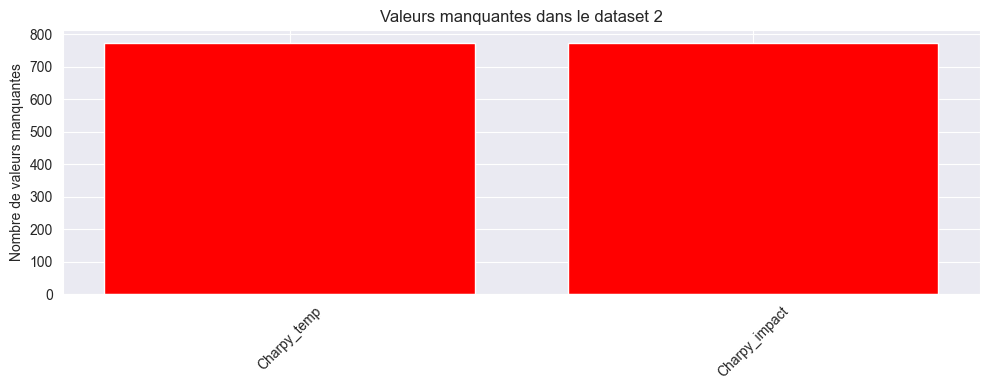

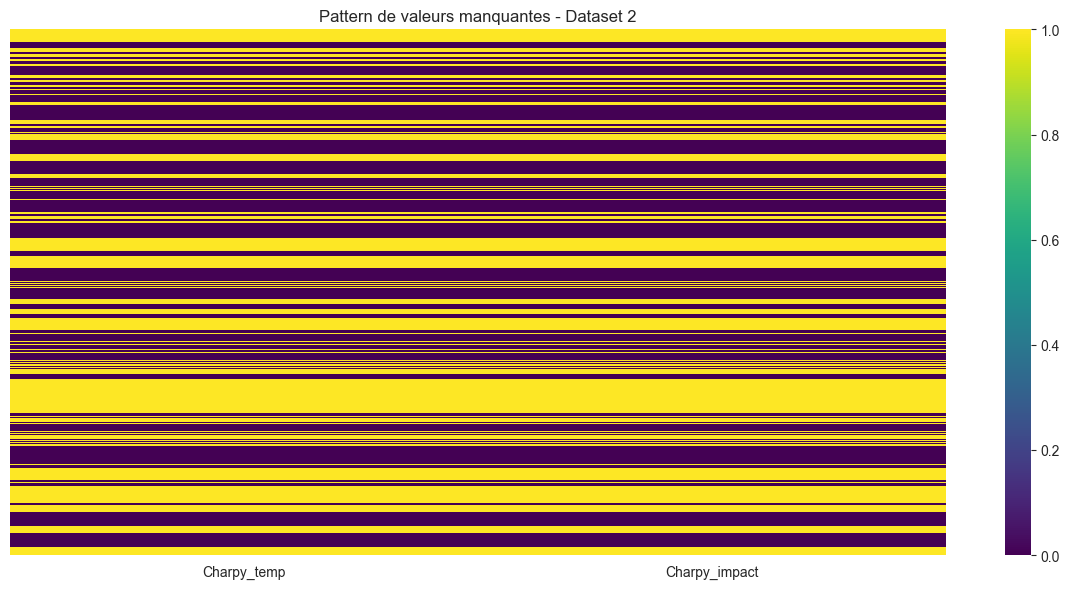


Statistiques des colonnes du dataset 2:
       Charpy_temp  Charpy_impact
count   879.000000      879.00000
mean    -34.606371       87.68942
std      34.738624       50.11670
min    -114.000000        3.00000
25%     -60.000000       38.00000
50%     -40.000000      100.00000
75%     -17.500000      100.00000
max     188.000000      270.00000


In [549]:
print(f"\nValeurs manquantes par colonne:")
print(df2[second_dataset_cols].isna().sum())
print(f"\nProportions manquantes:")
print((df2[second_dataset_cols].isna().sum() / len(df2) * 100).round(2))

# Visualisation des valeurs manquantes
fig, ax = plt.subplots(figsize=(10, 4))
missing_counts = df2[second_dataset_cols].isna().sum()
ax.bar(missing_counts.index, missing_counts.values, color=['red'])
ax.set_ylabel('Nombre de valeurs manquantes')
ax.set_title('Valeurs manquantes dans le dataset 2')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualisation du pattern de données manquantes
plt.figure(figsize=(12, 6))
sns.heatmap(df2[second_dataset_cols].isna(), cbar=True, cmap='viridis', yticklabels=False)
plt.title('Pattern de valeurs manquantes - Dataset 2')
plt.tight_layout()
plt.show()

# Statistiques descriptives des colonnes avec données non-manquantes
print(f"\nStatistiques des colonnes du dataset 2:")
print(df2[second_dataset_cols].describe())

On remarque que la température est en Celcius, pour éviter des problèmes liés au signe de la température on transforme ces températures en Kelvin (K) on va le faire à toutes les colonnes de températures
On remarque aussi que quand charpy impact est présent charpy temp aussi ce qui va simplifier notre imputation

In [550]:
# Identifier toutes les colonnes de température
temp_columns_in_df2 = [col for col in df2.columns if 'temp' in col.lower()]
print(f"\nColonnes de température détectées: {temp_columns_in_df2}")

for temp_col in temp_columns_in_df2:
    if temp_col in df2.columns:
        n_before = df2[temp_col].isna().sum()
        
        # Conversion seulement pour les valeurs non-manquantes
        mask = df2[temp_col].notna()
        df2.loc[mask, temp_col] = df2.loc[mask, temp_col] + 273.15
        
        n_after = df2[temp_col].isna().sum()
        
        print(f"\n{temp_col}:")
        print(f"Valeurs converties: {mask.sum()}")
        print(f"Nouvelles statistiques:")
        print(df2[temp_col].describe())




Colonnes de température détectées: ['Interpass_temp', 'PWHT_temp', 'Charpy_temp']

Interpass_temp:
Valeurs converties: 1652
Nouvelles statistiques:
count    1652.000000
mean      477.349803
std        39.375005
min       293.150000
25%       473.150000
50%       473.150000
75%       473.150000
max       573.150000
Name: Interpass_temp, dtype: float64

PWHT_temp:
Valeurs converties: 1652
Nouvelles statistiques:
count    1652.000000
mean      576.924487
std       284.776070
min       273.150000
25%       273.150000
50%       523.150000
75%       853.150000
max      1033.150000
Name: PWHT_temp, dtype: float64

Charpy_temp:
Valeurs converties: 879
Nouvelles statistiques:
count    879.000000
mean     238.543629
std       34.738624
min      159.150000
25%      213.150000
50%      233.150000
75%      255.650000
max      461.150000
Name: Charpy_temp, dtype: float64


On va passer à l'imputation toujours par adaboost mais on sauvegarde avant l'imputation pour pouvoir comparer ensuite

In [551]:
# Sauvegarder les distributions AVANT imputation
distributions_before = {}
for col in second_dataset_cols:
    distributions_before[col] = df2[col].dropna().copy()

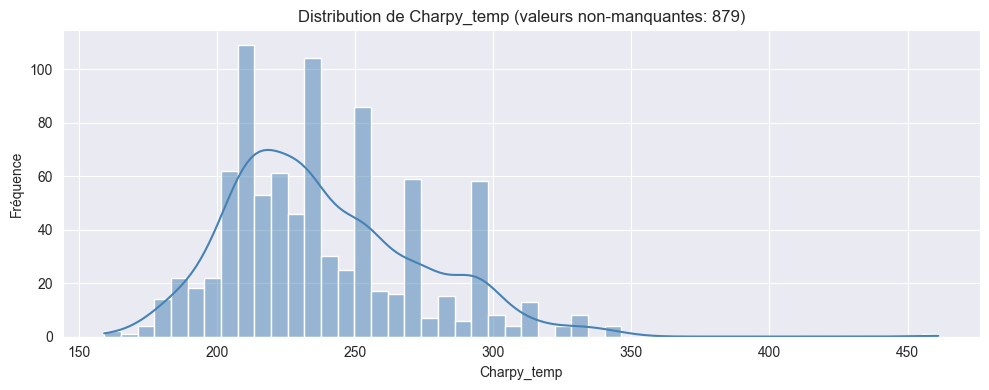

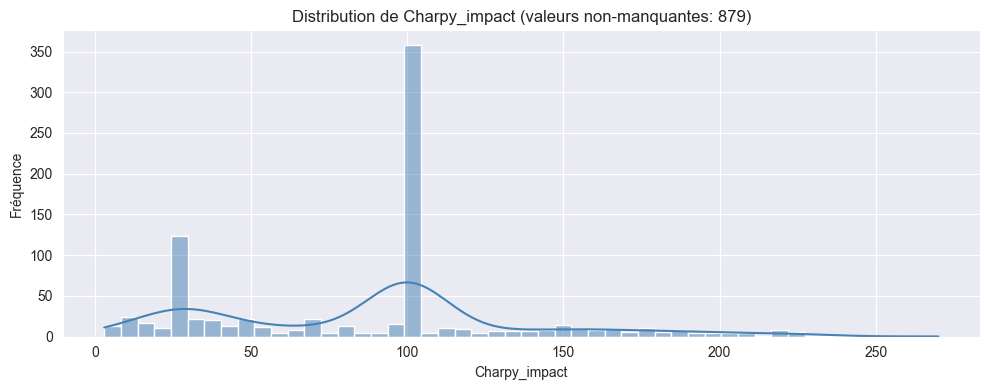

Fold RMSE for Charpy_temp: 26.019518926630024
Fold R2 for Charpy_temp: 32.38%

Fold RMSE for Charpy_temp: 29.22652831178422
Fold R2 for Charpy_temp: 28.75%

Fold RMSE for Charpy_temp: 29.179967186878383
Fold R2 for Charpy_temp: 27.52%

Fold RMSE for Charpy_temp: 28.33364163051937
Fold R2 for Charpy_temp: 36.43%

Fold RMSE for Charpy_temp: 29.862424229301627
Fold R2 for Charpy_temp: 33.47%

________________________________________

Fold RMSE for Charpy_impact: 47.76778718683467
Fold R2 for Charpy_impact: 17.97%

Fold RMSE for Charpy_impact: 44.58473659036255
Fold R2 for Charpy_impact: 6.27%

Fold RMSE for Charpy_impact: 47.60177129308757
Fold R2 for Charpy_impact: 21.83%

Fold RMSE for Charpy_impact: 43.42885447973279
Fold R2 for Charpy_impact: 14.51%

Fold RMSE for Charpy_impact: 44.63478314025831
Fold R2 for Charpy_impact: 19.56%

________________________________________

Charpy_temp: 773 valeurs imputées
Charpy_impact: 773 valeurs imputées

Vérification - Valeurs manquantes restantes

In [552]:
for col in second_dataset_cols:
    if df2[col].notna().sum() > 0:
        plt.figure(figsize=(10, 4))
        sns.histplot(df2[col].dropna(), bins=50, kde=True, color='steelblue')
        plt.title(f'Distribution de {col} (valeurs non-manquantes: {df2[col].notna().sum()})')
        plt.xlabel(col)
        plt.ylabel('Fréquence')
        plt.tight_layout()
        plt.show()

## Imputation des colonnes du dataset 2 avec Adaboost

from sklearn.ensemble import AdaBoostRegressor

df2_full = df2.copy()

imputation_models = {}

for col in second_dataset_cols:
    full = df2_full[list(set(df2_full.columns) - (set(second_dataset_cols) - {col}))].copy()
    full.dropna(inplace=True)

    cols = list(set(full.columns) - set(second_dataset_cols)) 

    X = full[cols]
    y = full[col]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = AdaBoostRegressor(n_estimators=100, random_state=42)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        #score = model.score(X_test, y_test)
        score = np.sqrt(np.mean((model.predict(X_test) - y_test) ** 2))
        print(f"Fold RMSE for {col}: {score}")
        print(f"Fold R2 for {col}: {model.score(X_test, y_test):.2%}\n")
    
    print("_"*40+"\n")
    model.fit(X, y)
    models[col] = (model, cols)


# Application de l'imputation pour les valeurs manquantes
for col in second_dataset_cols:
    if col in models:
        n_missing = df2[col].isna().sum()
        if n_missing > 0:
            model, feature_cols = models[col]
            indices_missing = df2.index[df2[col].isna()]
            
            X_missing = df2_full.loc[indices_missing, feature_cols]
            predictions = model.predict(X_missing)
            
            df2.loc[indices_missing, col] = predictions
            
            print(f"{col}: {n_missing} valeurs imputées")
        else:
            print(f"{col}: aucune valeur manquante")
    else:
        print(f"{col}: imputation non disponible (données insuffisantes)")

# Vérification finale
print(f"\nVérification - Valeurs manquantes restantes:")
print(df2[second_dataset_cols].isna().sum())

# Statistiques finales après imputation
print(f"\nStatistiques du dataset 2 après imputation:")
print(df2[second_dataset_cols].describe())

Comparons les données avant et après l'imputation

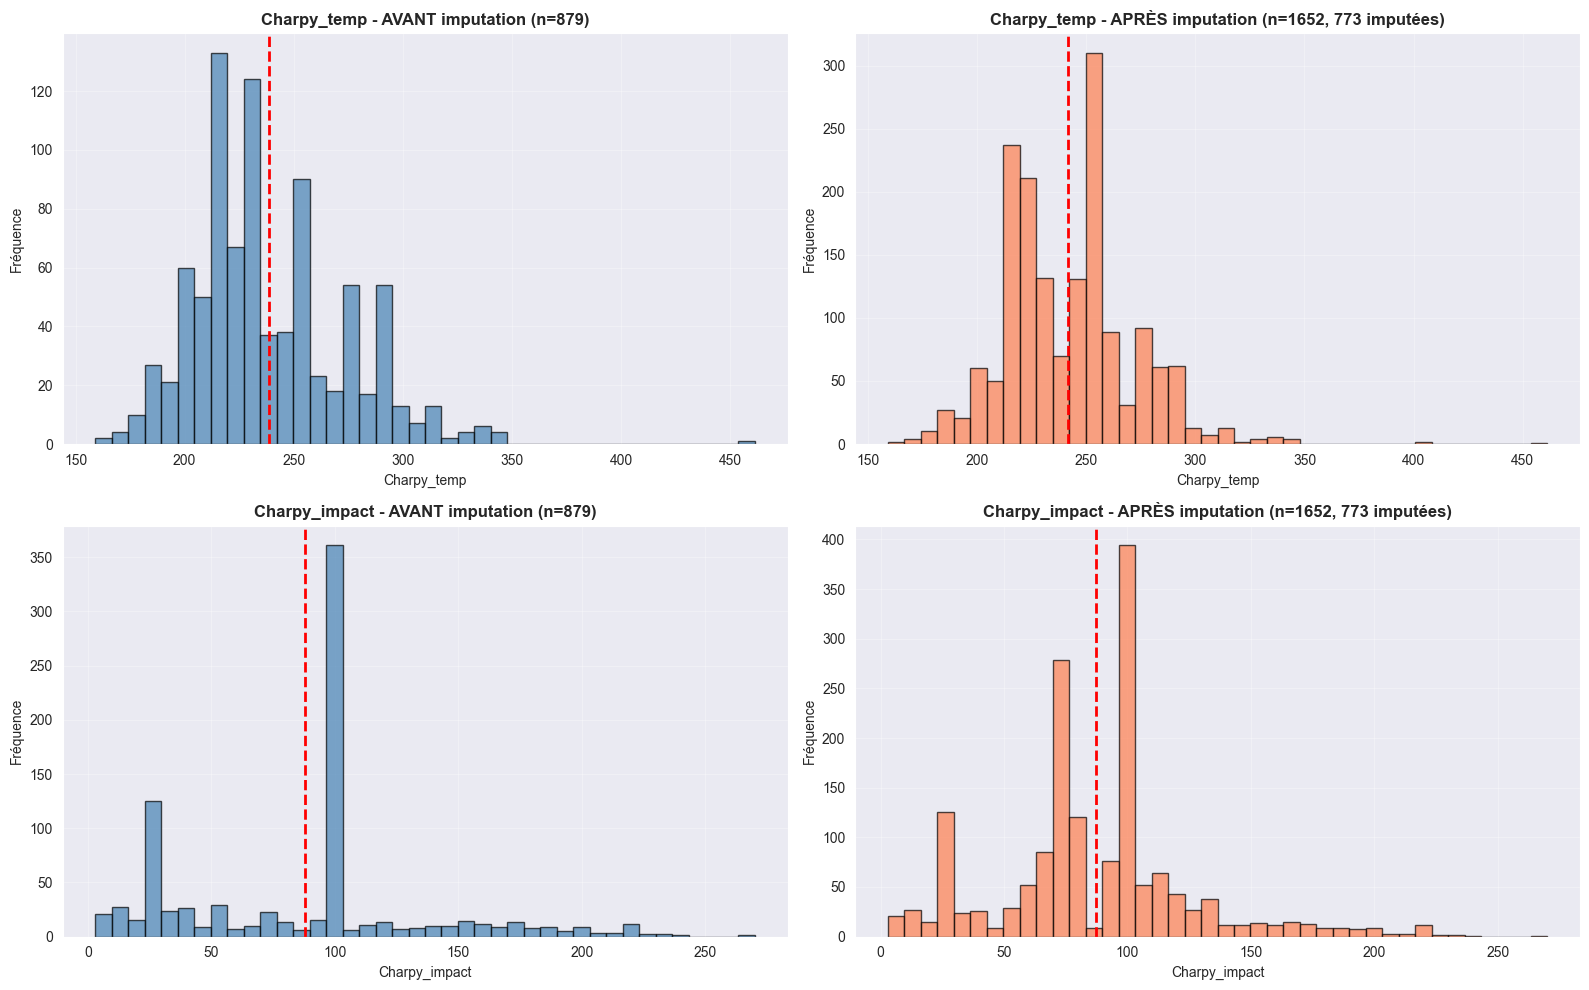


Charpy_temp:
  AVANT: n=879, mean=238.5436, std=34.7386
  APRÈS: n=1652, mean=241.8348, std=29.4547
  Changements: Δmean=+3.2912, Δstd=-5.2839

Charpy_impact:
  AVANT: n=879, mean=87.6894, std=50.1167
  APRÈS: n=1652, mean=87.2657, std=39.8368
  Changements: Δmean=-0.4238, Δstd=-10.2799


In [553]:
# Comparaison AVANT/APRÈS imputation
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, col in enumerate(second_dataset_cols):
    ax_before = axes[idx, 0]
    ax_before.hist(distributions_before[col], bins=40, alpha=0.7, color='steelblue', edgecolor='black')
    ax_before.set_title(f'{col} - AVANT imputation (n={len(distributions_before[col])})', fontweight='bold')
    ax_before.set_xlabel(col)
    ax_before.set_ylabel('Fréquence')
    ax_before.grid(True, alpha=0.3)
    ax_before.axvline(distributions_before[col].mean(), color='red', linestyle='--', linewidth=2)
    
    ax_after = axes[idx, 1]
    ax_after.hist(df2[col], bins=40, alpha=0.7, color='coral', edgecolor='black')
    n_imputed = len(df2[col]) - len(distributions_before[col])
    ax_after.set_title(f'{col} - APRÈS imputation (n={len(df2[col])}, {n_imputed} imputées)', fontweight='bold')
    ax_after.set_xlabel(col)
    ax_after.set_ylabel('Fréquence')
    ax_after.grid(True, alpha=0.3)
    ax_after.axvline(df2[col].mean(), color='red', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

for col in second_dataset_cols:
    print(f"\n{col}:")
    print(f"  AVANT: n={len(distributions_before[col])}, mean={distributions_before[col].mean():.4f}, std={distributions_before[col].std():.4f}")
    print(f"  APRÈS: n={len(df2[col])}, mean={df2[col].mean():.4f}, std={df2[col].std():.4f}")
    
    delta_mean = df2[col].mean() - distributions_before[col].mean()
    delta_std = df2[col].std() - distributions_before[col].std()
    print(f"  Changements: Δmean={delta_mean:+.4f}, Δstd={delta_std:+.4f}")


KNN Imputation - Test de différentes valeurs de k
KNN (k=3) - Valeurs manquantes restantes: 0
KNN (k=5) - Valeurs manquantes restantes: 0
KNN (k=7) - Valeurs manquantes restantes: 0
KNN (k=10) - Valeurs manquantes restantes: 0


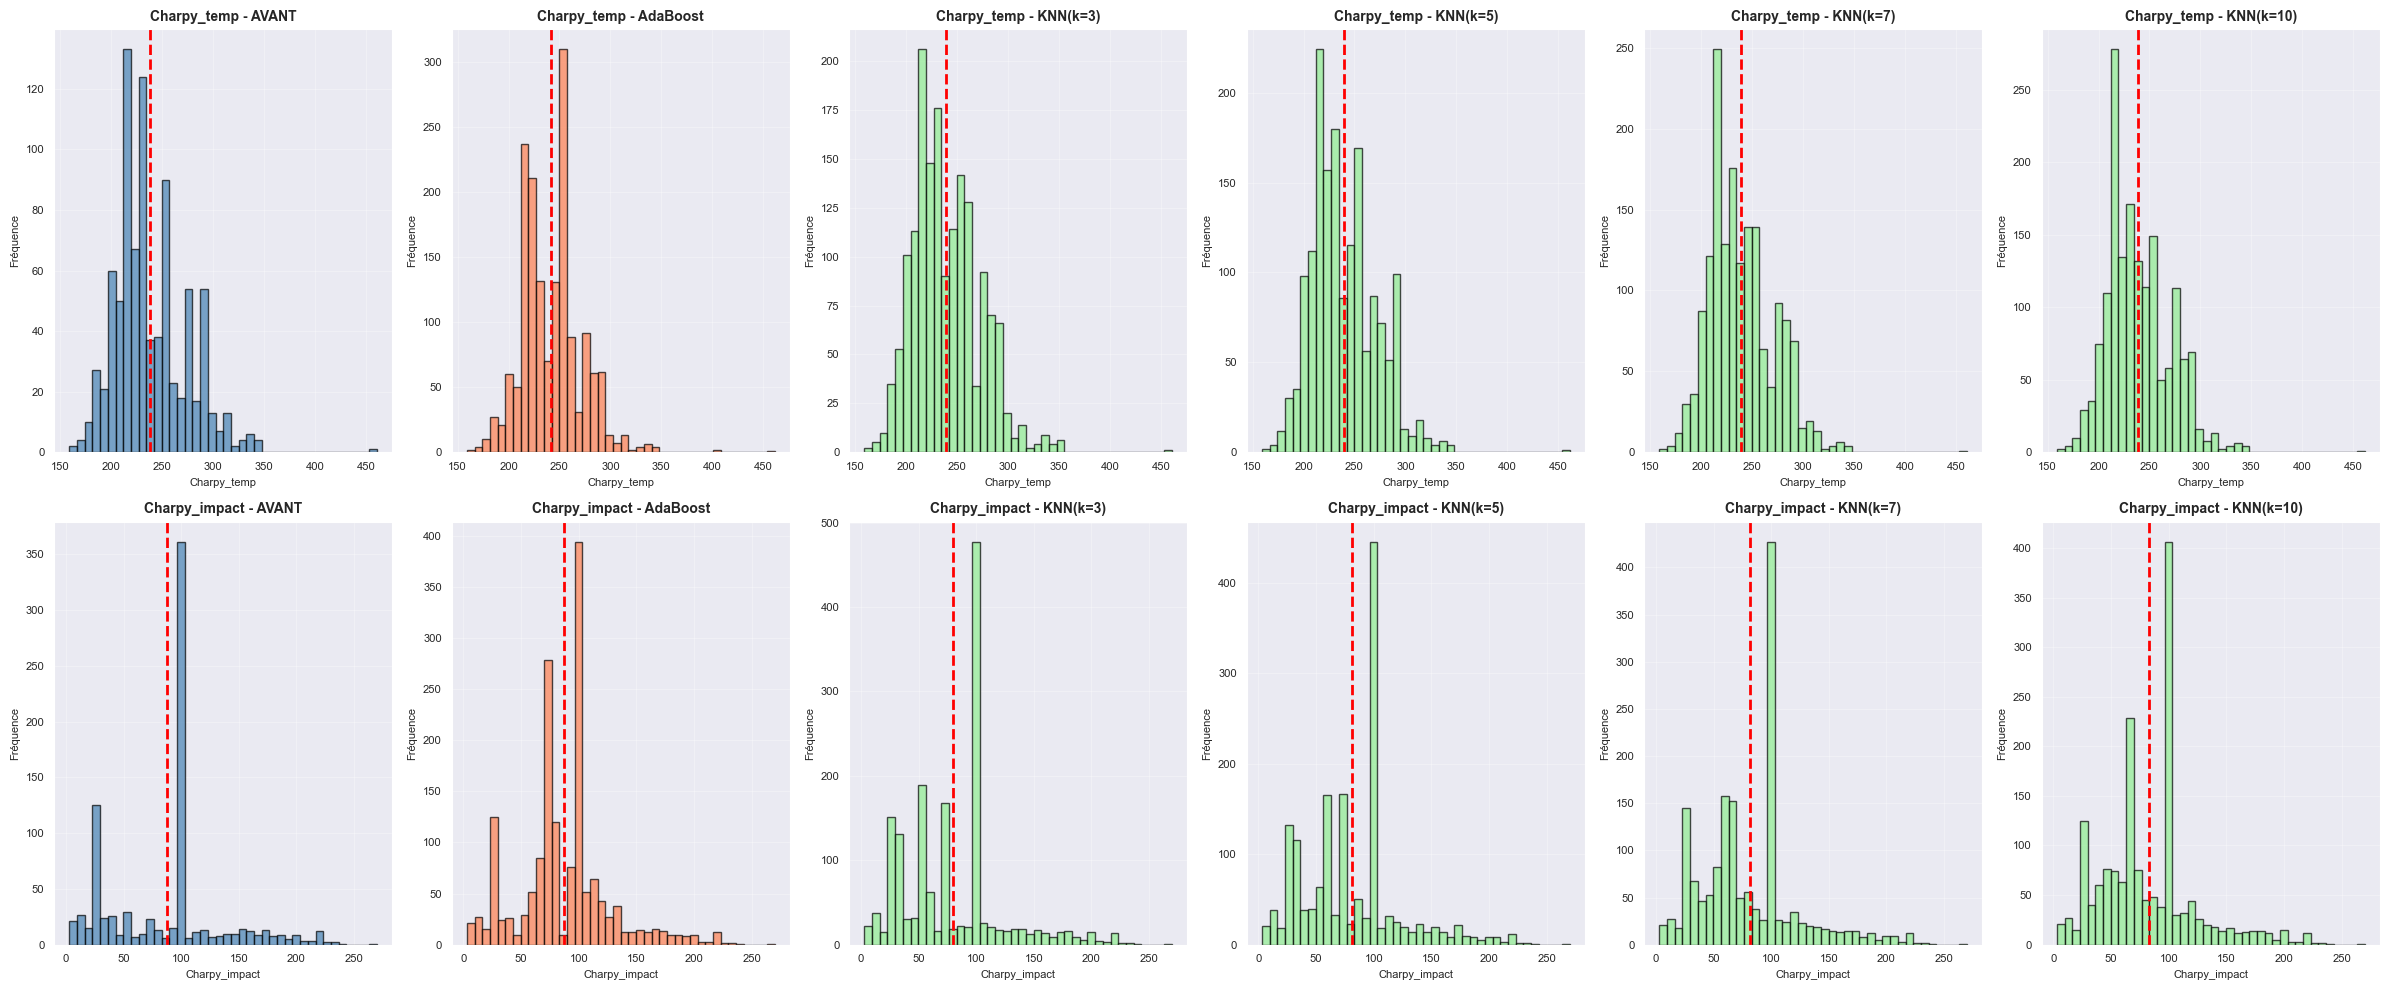


Comparaison détaillée:

Charpy_temp:
  AVANT:
    mean=238.5436, std=34.7386
  AdaBoost:
    mean=241.8348, std=29.4547
    Δmean=+3.2912, Δstd=-5.2839
  KNN (k=3):
    mean=239.6264, std=32.6250
    Δmean=+1.0828, Δstd=-2.1136
  KNN (k=5):
    mean=239.7119, std=32.0492
    Δmean=+1.1682, Δstd=-2.6894
  KNN (k=7):
    mean=239.2147, std=31.3554
    Δmean=+0.6711, Δstd=-3.3832
  KNN (k=10):
    mean=238.9514, std=30.7890
    Δmean=+0.4078, Δstd=-3.9497

Charpy_impact:
  AVANT:
    mean=87.6894, std=50.1167
  AdaBoost:
    mean=87.2657, std=39.8368
    Δmean=-0.4238, Δstd=-10.2799
  KNN (k=3):
    mean=80.0878, std=44.3321
    Δmean=-7.6016, Δstd=-5.7846
  KNN (k=5):
    mean=81.0321, std=43.5809
    Δmean=-6.6573, Δstd=-6.5358
  KNN (k=7):
    mean=81.6396, std=43.0244
    Δmean=-6.0498, Δstd=-7.0923
  KNN (k=10):
    mean=82.8395, std=42.6242
    Δmean=-4.8499, Δstd=-7.4925


Résumé des écarts (Δmean et Δstd):
--------------------------------------------------------------------------

In [554]:
from sklearn.impute import KNNImputer

# Tester plusieurs valeurs de k pour KNN
print("KNN Imputation - Test de différentes valeurs de k")
print("="*60)

scaler = StandardScaler()
numeric_cols = df2_full.select_dtypes(include=[np.number]).columns

k_values = [3, 5, 7, 10]
knn_results = {}

for k in k_values:
    df2_knn_temp = df2_full.copy()
    df2_knn_scaled = df2_full.copy()
    df2_knn_scaled[numeric_cols] = scaler.fit_transform(df2_full[numeric_cols])
    
    imputer_knn = KNNImputer(n_neighbors=k)
    df2_knn_scaled[numeric_cols] = imputer_knn.fit_transform(df2_knn_scaled[numeric_cols])
    df2_knn_temp[numeric_cols] = scaler.inverse_transform(df2_knn_scaled[numeric_cols])
    
    knn_results[k] = df2_knn_temp
    print(f"KNN (k={k}) - Valeurs manquantes restantes: {df2_knn_temp[second_dataset_cols].isna().sum().sum()}")

# Visualisation comparative: AVANT, AdaBoost, KNN(k=3,5,7,10)
fig, axes = plt.subplots(2, 6, figsize=(24, 10))

for idx, col in enumerate(second_dataset_cols):
    # AVANT
    axes[idx, 0].hist(distributions_before[col], bins=40, alpha=0.7, color='steelblue', edgecolor='black')
    axes[idx, 0].set_title(f'{col} - AVANT', fontweight='bold', fontsize=10)
    axes[idx, 0].set_xlabel(col, fontsize=8)
    axes[idx, 0].set_ylabel('Fréquence', fontsize=8)
    axes[idx, 0].grid(True, alpha=0.3)
    axes[idx, 0].axvline(distributions_before[col].mean(), color='red', linestyle='--', linewidth=2)
    axes[idx, 0].tick_params(labelsize=8)
    
    # AdaBoost
    axes[idx, 1].hist(df2[col], bins=40, alpha=0.7, color='coral', edgecolor='black')
    axes[idx, 1].set_title(f'{col} - AdaBoost', fontweight='bold', fontsize=10)
    axes[idx, 1].set_xlabel(col, fontsize=8)
    axes[idx, 1].set_ylabel('Fréquence', fontsize=8)
    axes[idx, 1].grid(True, alpha=0.3)
    axes[idx, 1].axvline(df2[col].mean(), color='red', linestyle='--', linewidth=2)
    axes[idx, 1].tick_params(labelsize=8)
    
    # KNN avec différents k
    for k_idx, k in enumerate(k_values):
        axes[idx, 2+k_idx].hist(knn_results[k][col], bins=40, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[idx, 2+k_idx].set_title(f'{col} - KNN(k={k})', fontweight='bold', fontsize=10)
        axes[idx, 2+k_idx].set_xlabel(col, fontsize=8)
        axes[idx, 2+k_idx].set_ylabel('Fréquence', fontsize=8)
        axes[idx, 2+k_idx].grid(True, alpha=0.3)
        axes[idx, 2+k_idx].axvline(knn_results[k][col].mean(), color='red', linestyle='--', linewidth=2)
        axes[idx, 2+k_idx].tick_params(labelsize=8)

plt.tight_layout()
plt.show()

# Tableau comparatif détaillé
print("\nComparaison détaillée:")
for col in second_dataset_cols:
    print(f"\n{col}:")
    print(f"  AVANT:")
    print(f"    mean={distributions_before[col].mean():.4f}, std={distributions_before[col].std():.4f}")
    print(f"  AdaBoost:")
    ab_mean = df2[col].mean()
    ab_std = df2[col].std()
    print(f"    mean={ab_mean:.4f}, std={ab_std:.4f}")
    print(f"    Δmean={ab_mean - distributions_before[col].mean():+.4f}, Δstd={ab_std - distributions_before[col].std():+.4f}")
    
    for k in k_values:
        knn_mean = knn_results[k][col].mean()
        knn_std = knn_results[k][col].std()
        print(f"  KNN (k={k}):")
        print(f"    mean={knn_mean:.4f}, std={knn_std:.4f}")
        print(f"    Δmean={knn_mean - distributions_before[col].mean():+.4f}, Δstd={knn_std - distributions_before[col].std():+.4f}")

# Résumé des différences par rapport à AVANT
print("\n\nRésumé des écarts (Δmean et Δstd):")
print("-"*80)
for col in second_dataset_cols:
    print(f"\n{col}:")
    print(f"  {'Méthode':<15} {'Δmean':<15} {'Δstd':<15}")
    print(f"  {'-'*45}")
    
    ab_mean_diff = df2[col].mean() - distributions_before[col].mean()
    ab_std_diff = df2[col].std() - distributions_before[col].std()
    print(f"  {'AdaBoost':<15} {ab_mean_diff:+.4f}        {ab_std_diff:+.4f}")
    
    for k in k_values:
        knn_mean_diff = knn_results[k][col].mean() - distributions_before[col].mean()
        knn_std_diff = knn_results[k][col].std() - distributions_before[col].std()
        print(f"  {'KNN(k='+str(k)+')':<15} {knn_mean_diff:+.4f}        {knn_std_diff:+.4f}")


# Merge des data

In [555]:
dataset_1 = data_optimized[df_1_targets]
dataset_2 = df2[['Charpy_impact', 'Charpy_temp']]

# Merge les datasets 1 et 2
final_dataset = pd.concat([df_common, dataset_1, dataset_2], axis=1)
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   C                     1652 non-null   float64
 1   Si                    1652 non-null   float64
 2   Mn                    1652 non-null   float64
 3   S                     1652 non-null   float64
 4   P                     1652 non-null   float64
 5   Ni                    1652 non-null   float64
 6   Cr                    1652 non-null   float64
 7   Mo                    1652 non-null   float64
 8   V                     1652 non-null   float64
 9   Cu                    1652 non-null   float64
 10  Co                    1652 non-null   float64
 11  W                     1652 non-null   float64
 12  O                     1652 non-null   float64
 13  Ti                    1652 non-null   float64
 14  N                     1652 non-null   float64
 15  Al                   

Vérifier que le dataset1_clean ne contient pas trop de valeurs manquantes dans les colonnes des propriétés mécaniques.

In [556]:
# Vérifier les valeurs manquantes dans le dataset final
print("Total de NaN dans le dataset:", np.isnan(final_dataset).sum())

Total de NaN dans le dataset: C                       0
Si                      0
Mn                      0
S                       0
P                       0
Ni                      0
Cr                      0
Mo                      0
V                       0
Cu                      0
Co                      0
W                       0
O                       0
Ti                      0
N                       0
Al                      0
B                       0
Nb                      0
Sn                      0
As                      0
Sb                      0
Current                 0
Voltage                 0
Heat_input              0
Interpass_temp          0
PWHT_temp               0
PWHT_time               0
Weld_type_FCA           0
Weld_type_GMAA          0
Weld_type_GTAA          0
Weld_type_MMA           0
Weld_type_NGGMA         0
Weld_type_NGSAW         0
Weld_type_SA            0
Weld_type_SAA           0
Weld_type_ShMA          0
Weld_type_TSA           0
AC_DC_AC

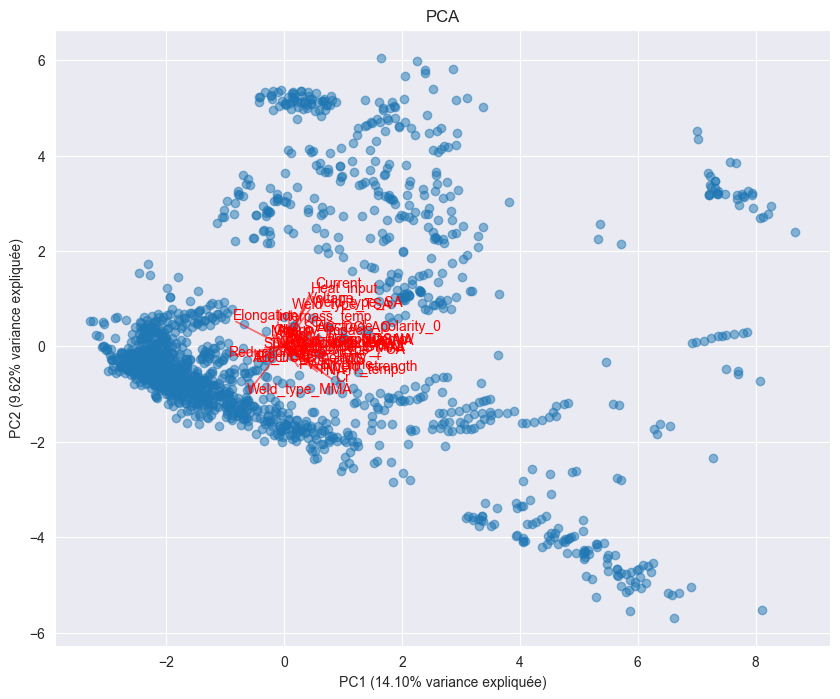

In [557]:
# Préparer les données
X = final_dataset.copy()

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer la PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualiser les résultats
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance expliquée)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance expliquée)')

# Ajouter les vecteurs de contribution
for i, (comp1, comp2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, comp1*3, comp2*3, color='r', alpha=0.5)
    plt.text(comp1*3.2, comp2*3.2, final_dataset.columns[i], color='r')

plt.grid(True)
plt.show()

Analyse des contributions des variables aux composantes principales (affichage des 10 contributions les plus fortes).

In [558]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
contrib = pd.DataFrame(
    loadings**2,
    columns=['PC1', 'PC2'],
    index=final_dataset.columns
)
contrib['Total'] = contrib.sum(axis=1)
contrib.sort_values('Total', ascending=False)

contrib_sorted = contrib.sort_values("Total", ascending=False)
print(contrib_sorted.head(10))

                     PC1       PC2     Total
Current         0.180521  0.679696  0.860217
Cr              0.494864  0.241368  0.736232
Heat_input      0.137216  0.590113  0.727329
Weld_type_MMA   0.261709  0.436825  0.698533
Mo              0.631594  0.059600  0.691194
Elongation      0.508040  0.139466  0.647506
UTS             0.572758  0.058885  0.631643
Reduction_area  0.573377  0.018456  0.591834
Yield_strength  0.405648  0.111357  0.517005
Voltage         0.110971  0.387306  0.498276


PCA avec les colonnes qui contribuent le plus à la PCA : Current, Cr, Heat_input, Weld_type_MMA, Mo, Elongation, UTS, Reduction_area, Yield_strength, Voltage

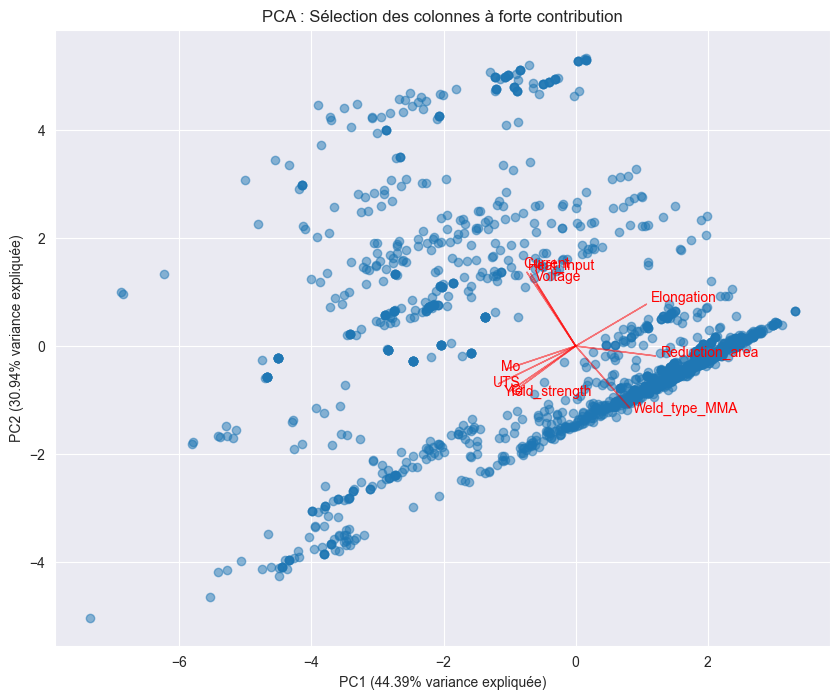

In [559]:
cols = [
    'Current',
    'Cr',
    'Heat_input',
    'Weld_type_MMA',
    'Mo',
    'Elongation',
    'UTS',
    'Reduction_area',
    'Yield_strength',
    'Voltage'
]
X_subset = final_dataset[cols]
X_subset_scaled = scaler.fit_transform(X_subset)
pca_subset = PCA(n_components=2)
X_subset_pca = pca_subset.fit_transform(X_subset_scaled)

# Visualiser les résultats
plt.figure(figsize=(10, 8))
plt.scatter(X_subset_pca[:, 0], X_subset_pca[:, 1], alpha=0.5)
plt.title('PCA : Sélection des colonnes à forte contribution')
plt.xlabel(f'PC1 ({pca_subset.explained_variance_ratio_[0]:.2%} variance expliquée)')
plt.ylabel(f'PC2 ({pca_subset.explained_variance_ratio_[1]:.2%} variance expliquée)')

# Ajouter les vecteurs de contribution
for i, (comp1, comp2) in enumerate(zip(pca_subset.components_[0], pca_subset.components_[1])):
    plt.arrow(0, 0, comp1*3, comp2*3, color='r', alpha=0.5)
    plt.text(comp1*3.2, comp2*3.2, X_subset.columns[i], color='r')
plt.grid(True)
plt.show()

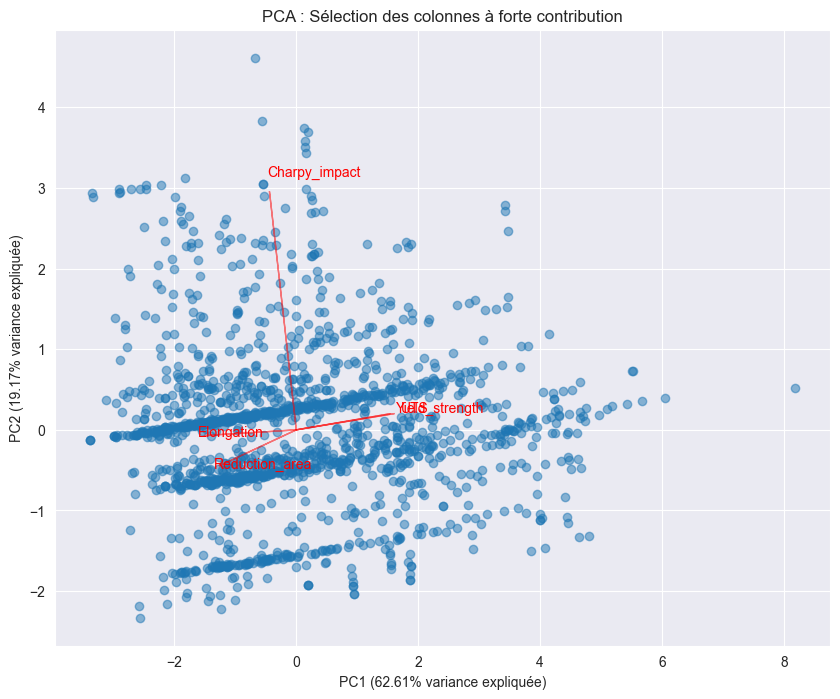

In [560]:
cols = list(set(first_dataset_cols + second_dataset_cols) - {'Charpy_temp'})

X_subset = final_dataset[cols]

X_subset_scaled = scaler.fit_transform(X_subset)
pca_subset = PCA(n_components=2)
X_subset_pca = pca_subset.fit_transform(X_subset_scaled)

comp1 = 0
comp2 = 1
# Visualiser les résultats
plt.figure(figsize=(10, 8))
plt.scatter(X_subset_pca[:, comp1], X_subset_pca[:, comp2], alpha=0.5)
plt.title('PCA : Sélection des colonnes à forte contribution')
plt.xlabel(f'PC1 ({pca_subset.explained_variance_ratio_[comp1]:.2%} variance expliquée)')
plt.ylabel(f'PC2 ({pca_subset.explained_variance_ratio_[comp2]:.2%} variance expliquée)')

# Ajouter les vecteurs de contribution
for i, (comp1, comp2) in enumerate(zip(pca_subset.components_[comp1], pca_subset.components_[comp2])):
    plt.arrow(0, 0, comp1*3, comp2*3, color='r', alpha=0.5)
    plt.text(comp1*3.2, comp2*3.2, X_subset.columns[i], color='r')
plt.grid(True)
plt.show()

In [561]:
X_subset.columns

Index(['Yield_strength', 'Reduction_area', 'Charpy_impact', 'Elongation',
       'UTS'],
      dtype='object')

On voit grâce à cette PCA que les variables UTS, Yield_strength, Elongation et Reduction_area sont très corrélés à l'axe de PC1 et Charpy_impact est très corrélé à l'axe PC2.

Grâce à cette PCA on peut observer 4 catégories :

- Quadrant Haut-Droit (PC1 > 0, PC2 > 0) :

    - Profil "Premium" : Résistant et résilient, La soudure est solide, ne se déforme pas facilement (PC1+) et absorbe très bien les chocs sans casser (PC2+).

- Quadrant Haut-Gauche (PC1 < 0, PC2 > 0) :
    - Profil "Ductile-Résilient" : La soudure se déforme beaucoup (PC1-) et absorbe les chocs (PC2+).

- Quadrant Bas-Droit (PC1 > 0, PC2 < 0) :
    - Profil "Résistant-Fragile" : Soudure dure mais peu résistance à l'impact.

- Quadrant Bas-Gauche (PC1 < 0, PC2 < 0) :
    - Profil "Standard" : Profil le moins performant, la soudure se déforme facilement et casse facilement.

On va donc assigner cela comme label à nos soudures.

In [562]:
X_subset_pca

array([[-2.49681526,  0.13211204],
       [-2.63507536, -0.05983997],
       [-2.98483595, -0.08083668],
       ...,
       [ 1.75249367, -0.23151398],
       [ 4.09420464,  0.14004745],
       [ 3.68068719,  0.07672548]], shape=(1652, 2))

In [563]:
def labelization(arr):
    labels = []
    for i in range(arr.shape[0]):
        if arr[i, 0] >= 0 and arr[i, 1] >= 0:
            labels.append('Premium')
        elif arr[i, 0] < 0 and arr[i, 1] >= 0:
            labels.append('Ductile-Resilient')
        elif arr[i, 0] < 0 and arr[i, 1] < 0:
            labels.append('Resistant-Fragile')
        else:
            labels.append('Standard')
    return labels

pca_df = pd.DataFrame(X_subset_pca, columns=['PC1', 'PC2'])
pca_df['label'] = np.select(
    [
        (pca_df['PC1'] >= 0) & (pca_df['PC2'] >= 0),
        (pca_df['PC1'] < 0) & (pca_df['PC2'] >= 0),
        (pca_df['PC1'] >= 0) & (pca_df['PC2'] < 0)
    ],
    ['Premium', 'Ductile-Resilient', 'Resistant-Fragile'],
    default='Standard'
)

pca_df

,PC1,PC2,label
0,-2.496815,0.132112,Ductile-Resilient
1,-2.635075,-0.059840,Standard
2,-2.984836,-0.080837,Standard
3,-2.160807,0.400499,Ductile-Resilient
4,-2.119703,0.001622,Ductile-Resilient
...,...,...,...
1647,3.843620,0.129947,Premium
1648,4.749686,0.268101,Premium
1649,1.752494,-0.231514,Resistant-Fragile
1650,4.094205,0.140047,Premium


# Trouver un label de qualité

PCA en 2D sur les colonnes qui peuvent se rapporter à la qualité pour faire une visualisation dans le même style que celle du cours avec la criminalité pour espérer avoir un label cohérent. 

In [564]:
# TODO

# K-Means Clustering pour la classification des soudures

On va utiliser K-Means avec 4 clusters pour classer nos soudures et vérifier l'approche par 4 clusters à l'aide des métriques Elbow et Calinski

In [565]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [566]:
kmeans_clustering_features = ['Yield_strength', 'UTS', 'Elongation', 'Reduction_area', 'Charpy_impact']

df_X_kmeans_clustering: pd.DataFrame = final_dataset[kmeans_clustering_features].copy()

scaler_kmeans = StandardScaler()
X_clustering_scaled = scaler_kmeans.fit_transform(df_X_kmeans_clustering)

df_X_kmeans_clustering.describe()

,Yield_strength,UTS,Elongation,Reduction_area,Charpy_impact
count,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000
mean,506.514224,600.005203,26.004727,71.317550,87.265659
std,93.383007,93.315705,4.944017,9.140827,39.836763
min,315.000000,444.005646,10.600000,17.000000,3.000000
25%,442.778656,533.801804,22.760330,67.000000,69.842838
50%,492.000000,576.101074,26.800000,74.347694,91.990991
75%,552.579819,652.000000,29.890289,77.886719,100.000000
max,920.000000,1151.000000,37.000000,83.000000,270.000000


## Verifier le nombre optimal de clusters
On estime le nombre de clusters à 4 grâce aux analyses effectuées précédement. Ici, on va vérifier si notre théorie est validable.

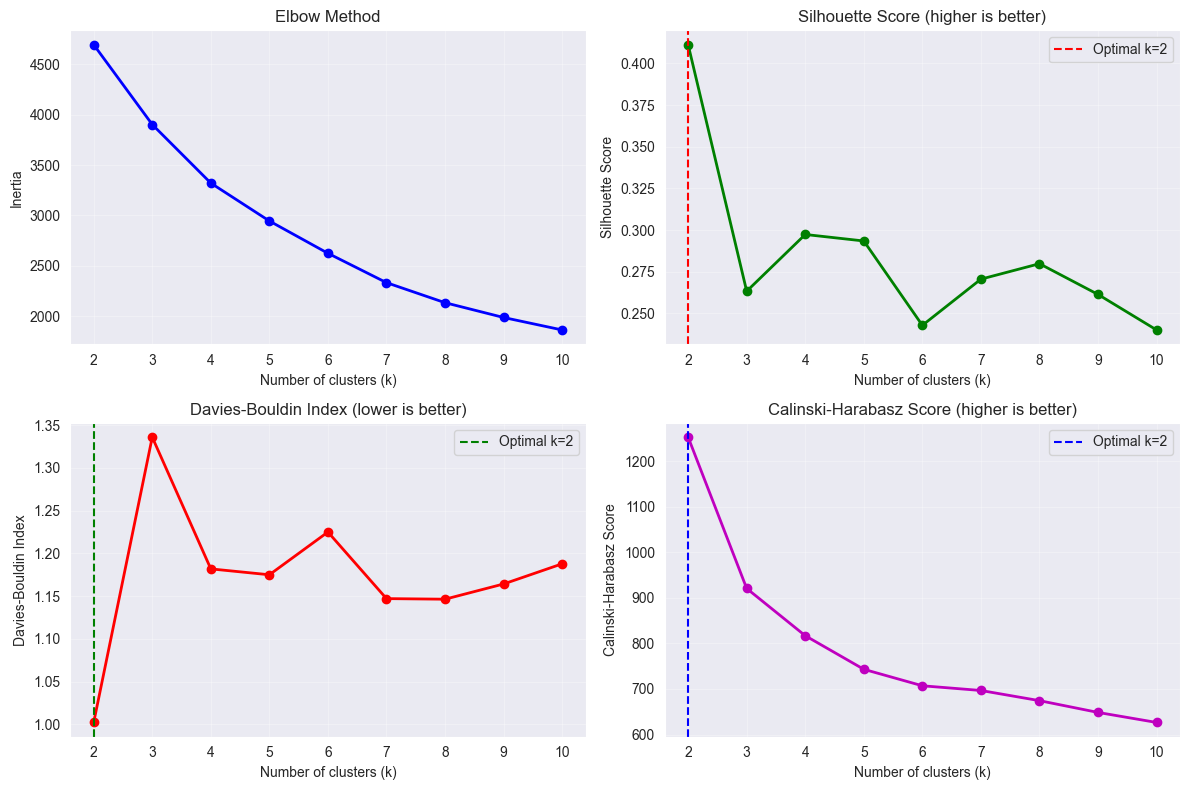


Optimal k values:
  silhouette: k=2
  davies_bouldin: k=2
  calinski_harabasz: k=2

Metrics summary:
    k      inertia  silhouette  davies_bouldin  calinski_harabasz
0   2  4694.431490    0.411203        1.002318        1253.226946
1   3  3901.947576    0.263266        1.336048         920.877114
2   4  3320.765406    0.297315        1.181973         817.066511
3   5  2944.562338    0.293415        1.175085         743.279037
4   6  2623.973027    0.242797        1.225101         707.089567
5   7  2332.505637    0.270511        1.147194         696.728954
6   8  2133.535958    0.279781        1.146500         674.393996
7   9  1986.651953    0.261341        1.164313         648.522683
8  10  1862.926317    0.240024        1.187905         626.493138


In [567]:
# On utilise des fonctions pourencapsuler le code, limiter la saturation des variables et permettre de libérer la mémoire
def show_optimal_kmeans_k(X_scaled: pd.DataFrame, k_range: list =range(2, 11), random_state: int =42) -> dict:
    metrics_data = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X_scaled)

        metrics_data.append({
            'k': k,
            'inertia': kmeans.inertia_,
            'silhouette': silhouette_score(X_scaled, labels),
            'davies_bouldin': davies_bouldin_score(X_scaled, labels),
            'calinski_harabasz': calinski_harabasz_score(X_scaled, labels)
        })

    metrics_df = pd.DataFrame(metrics_data)

    optimal_k = {
        'silhouette': metrics_df.loc[metrics_df['silhouette'].idxmax(), 'k'],
        'davies_bouldin': metrics_df.loc[metrics_df['davies_bouldin'].idxmin(), 'k'],
        'calinski_harabasz': metrics_df.loc[metrics_df['calinski_harabasz'].idxmax(), 'k']
    }

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Elbow
    axes[0, 0].plot(metrics_df['k'], metrics_df['inertia'], 'bo-', linewidth=2)
    axes[0, 0].set_xlabel('Number of clusters (k)')
    axes[0, 0].set_ylabel('Inertia')
    axes[0, 0].set_title('Elbow Method')
    axes[0, 0].grid(True, alpha=0.3)

    # Silhouette
    axes[0, 1].plot(metrics_df['k'], metrics_df['silhouette'], 'go-', linewidth=2)
    axes[0, 1].axvline(optimal_k['silhouette'], color='red', linestyle='--',
                       label=f"Optimal k={int(optimal_k['silhouette'])}")
    axes[0, 1].set_xlabel('Number of clusters (k)')
    axes[0, 1].set_ylabel('Silhouette Score')
    axes[0, 1].set_title('Silhouette Score (higher is better)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Davies-Bouldin
    axes[1, 0].plot(metrics_df['k'], metrics_df['davies_bouldin'], 'ro-', linewidth=2)
    axes[1, 0].axvline(optimal_k['davies_bouldin'], color='green', linestyle='--',
                       label=f"Optimal k={int(optimal_k['davies_bouldin'])}")
    axes[1, 0].set_xlabel('Number of clusters (k)')
    axes[1, 0].set_ylabel('Davies-Bouldin Index')
    axes[1, 0].set_title('Davies-Bouldin Index (lower is better)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Calinski-Harabasz
    axes[1, 1].plot(metrics_df['k'], metrics_df['calinski_harabasz'], 'mo-', linewidth=2)
    axes[1, 1].axvline(optimal_k['calinski_harabasz'], color='blue', linestyle='--',
                       label=f"Optimal k={int(optimal_k['calinski_harabasz'])}")
    axes[1, 1].set_xlabel('Number of clusters (k)')
    axes[1, 1].set_ylabel('Calinski-Harabasz Score')
    axes[1, 1].set_title('Calinski-Harabasz Score (higher is better)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'metrics': metrics_df,
        'optimal_k': optimal_k
    }

cluster_evaluation = show_optimal_kmeans_k(X_clustering_scaled)
print("\nOptimal k values:")
for metric, k in cluster_evaluation['optimal_k'].items():
    print(f"  {metric}: k={int(k)}")
print("\nMetrics summary:")
print(cluster_evaluation['metrics'])

On voit que les méthodes calculées suggères un K à 2 ... mais compte tenu de l'analyse des données et de l'allure de la courbe Elbow, on va essayer un K = 4 tout de même.

## K-Means Model avec k=4

In [568]:
selected_k = 4

kmeans = KMeans(n_clusters=selected_k, random_state=42, n_init=10)

cluster_labels = kmeans.fit_predict(X_clustering_scaled)

final_dataset['Cluster'] = cluster_labels

print(f"Clustering K-means  avec k={4}")
print(f"Distribution en % :")
print((final_dataset['Cluster'].value_counts(normalize=True).sort_index() * 100).round(2))

Clustering K-means  avec k=4
Distribution en % :
Cluster
0    46.37
1    13.92
2     8.72
3    30.99
Name: proportion, dtype: float64


## Info sur les Clusters

In [569]:
cluster_stats = final_dataset.groupby('Cluster')[kmeans_clustering_features].agg(['mean', 'std', 'min', 'max'])

for cluster_id in range(selected_k):
    print(f"{'='*80}")
    print(f"CLUSTER {cluster_id} (n={(cluster_labels == cluster_id).sum()} samples, "
          f"{(cluster_labels == cluster_id).sum()/len(cluster_labels)*100:.1f}%)")
    print(f"{'='*80}")

    for feature in kmeans_clustering_features:
        mean_val = cluster_stats.loc[cluster_id, (feature, 'mean')]
        std_val = cluster_stats.loc[cluster_id, (feature, 'std')]
        print(f"{feature:20s}: {mean_val:8.2f} ± {std_val:6.2f}")

cluster_comparison = final_dataset.groupby('Cluster')[kmeans_clustering_features].mean()

# Normalisation pour comparer plus facilement
cluster_comparison_normalized = (cluster_comparison - cluster_comparison.min()) / (cluster_comparison.max() - cluster_comparison.min())
print("="*80)
print("NORMALIZED CLUSTER COMPARISON (0-1 scale)")
print("="*80)
print(cluster_comparison_normalized.round(3))

CLUSTER 0 (n=766 samples, 46.4%)
Yield_strength      :   442.70 ±  43.45
UTS                 :   533.14 ±  35.24
Elongation          :    29.49 ±   2.55
Reduction_area      :    76.81 ±   3.86
Charpy_impact       :    81.27 ±  28.51
CLUSTER 1 (n=230 samples, 13.9%)
Yield_strength      :   663.79 ±  81.85
UTS                 :   766.02 ±  69.14
Elongation          :    18.72 ±   3.50
Reduction_area      :    58.03 ±  11.53
Charpy_impact       :    70.74 ±  30.33
CLUSTER 2 (n=144 samples, 8.7%)
Yield_strength      :   462.58 ±  52.51
UTS                 :   560.98 ±  52.25
Elongation          :    28.41 ±   3.32
Reduction_area      :    72.27 ±   5.51
Charpy_impact       :   172.09 ±  30.69
CLUSTER 3 (n=512 samples, 31.0%)
Yield_strength      :   543.69 ±  49.08
UTS                 :   636.44 ±  50.05
Elongation          :    23.38 ±   3.17
Reduction_area      :    68.80 ±   6.96
Charpy_impact       :    79.80 ±  31.22
NORMALIZED CLUSTER COMPARISON (0-1 scale)
         Yield_strength    

## Nommage des Clusters à partir des propriétés

@todo
Ici il faut nommer les Clusters en fonction de leurs caractéristiques. Il faudrait probablement croisé les données présentes dans les Clusters avec des données métiers précises, ce qui est assez dur à trouver et mettre en oeuvre...

## Visulation des clusters en 2D

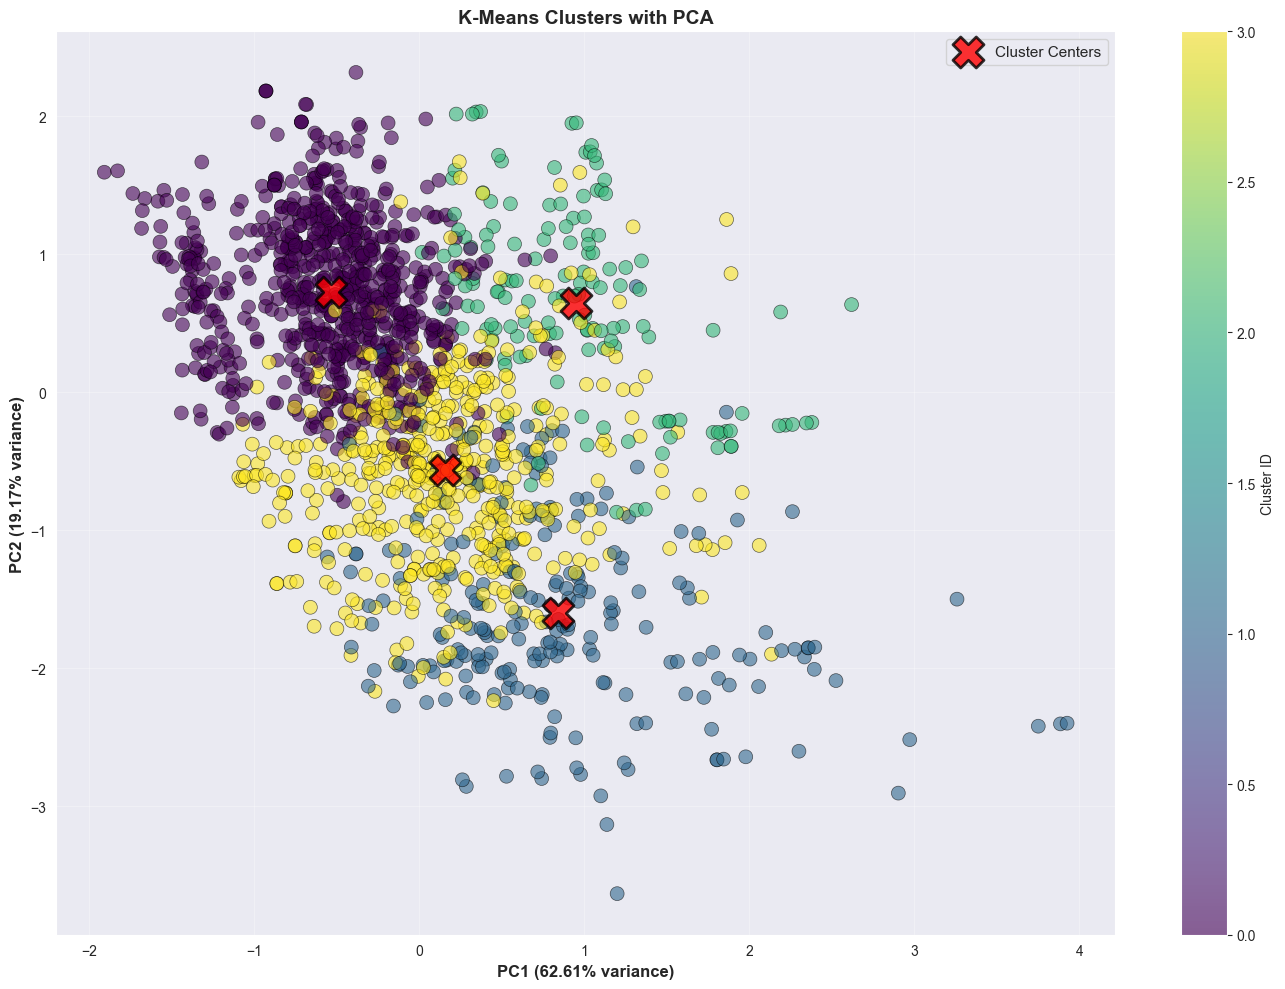

In [570]:
X_clustering_pca = pca_subset.transform(X_clustering_scaled)

plt.figure(figsize=(14, 10))
scatter = plt.scatter(X_clustering_pca[:, 0], X_clustering_pca[:, 1],
                     c=cluster_labels, cmap='viridis',
                     s=100, alpha=0.6, edgecolors='black', linewidth=0.5)

centers_pca = pca_subset.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
           c='red', s=500, alpha=0.8, edgecolors='black', linewidth=2,
           marker='X', label='Cluster Centers')

plt.colorbar(scatter, label='Cluster ID')
plt.xlabel(f'PC1 ({pca_subset.explained_variance_ratio_[0]:.2%} variance)', fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({pca_subset.explained_variance_ratio_[1]:.2%} variance)', fontsize=12, fontweight='bold')
plt.title('K-Means Clusters with PCA', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
pca_3d = PCA(n_components=3)
X_clustering_pca_3d = pca_3d.fit_transform(X_clustering_scaled)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_clustering_pca_3d[:, 0],
                    X_clustering_pca_3d[:, 1],
                    X_clustering_pca_3d[:, 2],
                    c=cluster_labels,
                    cmap='viridis',
                    s=50,
                    alpha=0.6,
                    edgecolors='black',
                    linewidth=0.5)

centers_pca_3d = pca_3d.transform(kmeans.cluster_centers_)
ax.scatter(centers_pca_3d[:, 0],
          centers_pca_3d[:, 1],
          centers_pca_3d[:, 2],
          c='red',
          s=500,
          alpha=0.9,
          edgecolors='black',
          linewidth=2,
          marker='X',
          label='Cluster Centers')

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})', fontsize=11, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})', fontsize=11, fontweight='bold')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})', fontsize=11, fontweight='bold')
ax.set_title('K-Means Clusters in 3D PCA Space', fontsize=14, fontweight='bold', pad=20)

cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('Cluster ID', fontsize=11, fontweight='bold')

ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

On peut identifier de potentiels clusters, mais comment les nommer ?

# Fit des modèles sur le label créé